In [17]:
%pip install lightgbm -U

Note: you may need to restart the kernel to use updated packages.


In [35]:
# Imports
import pandas as pd
import numpy as np
import sys

from datetime import datetime as dt

# Scikit-learn
from sklearn.experimental import enable_iterative_imputer, enable_halving_search_cv
from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.metrics import *

from sklearn.impute import *
from imblearn.combine import *
from imblearn.over_sampling import *
from imblearn.under_sampling import *
from imblearn.combine import *
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import *
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import *
from xgboost import XGBClassifier
from lightgbm import *
from sklearn.svm import *
from sklearn.feature_selection import *
from scipy.stats import *

import missingno as msno
import prince

import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
def fit_model(x_train, y_train, estimator, cv):
  avg_fit_time = []
  sd_fit_time = []
  max_fit_time = []

  avg_train_score = []
  sd_train_score = []
  max_train_score = []
  min_train_score = []

  avg_test_score = []
  sd_test_score = []
  max_test_score = []
  min_test_score = []
  
  estimator_cv = []

  for est in estimator:
    print('\nCurrent:', est)
    score = cross_validate(est, x_train, y_train, scoring = 'f1', cv = cv, return_train_score=True, return_estimator = True,
                           n_jobs = -1, verbose = 1)
    
    avg_fit_time.append(np.mean(score['fit_time']))
    sd_fit_time.append(np.std(score['fit_time']))
    max_fit_time.append(np.max(score['fit_time']))

    avg_train_score.append(np.mean(score['train_score']))
    sd_train_score.append(np.std(score['train_score']))
    max_train_score.append(np.max(score['train_score']))
    min_train_score.append(np.min(score['train_score']))

    avg_test_score.append(np.mean(score['test_score']))
    sd_test_score.append(np.std(score['test_score']))
    max_test_score.append(np.max(score['test_score']))
    min_test_score.append(np.min(score['test_score']))

    param = []
    for i in score['estimator']:
      param.append(i.get_params())
    
    estimator_cv.append(param)

  result = pd.DataFrame({
    'model' : estimator,
    'avg_fit_time' : avg_fit_time,
    'sd_fit_time' : sd_fit_time,
    'max_fit_time' : max_fit_time,

    'avg_train_score' : avg_train_score,
    'sd_train_score' : sd_train_score,
    'max_train_score' : max_train_score,
    'min_train_score' : min_train_score,

    'avg_test_score' : avg_test_score,
    'sd_test_score' : sd_test_score,
    'max_test_score' : max_test_score,
    'min_test_score' : min_test_score,

    'estimators' : estimator_cv,
  })

  return(result)

In [3]:
df = pd.read_csv('train.csv')
df['DC201'] = [0 if i == 'Layak Minum' else 1 for i in df['DC201']]

df_test = pd.read_csv('test.csv')
df.head()

,id,DC024,DC025,DC205,DC206,DC207,DC208,DC209,DC210,DC211,...,DC237f,DC241,DC242,DC244,DC246,DC252,DC270a,DC109,DC142a,DC201
0,1,11,2,16.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,2.0,1,12.0,60.0,0
1,2,11,2,31.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,1.0,2,31.0,70.0,0
2,3,11,2,12.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,4,11.0,75.0,0
3,6,11,2,12.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,2.0,NaN,1.0,0.0,1.0,1,11.0,85.0,0
4,7,11,2,12.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,2,11.0,65.0,0


# Split X y

In [13]:
X = df.drop(['id','DC109', 'DC201'], axis = 1)
y = df['DC201']
X_test = df_test.drop(['DC109', 'id'], axis = 1)
X_test_id = df_test['id']

# Replace Low Frequency values with NaN

In [14]:
threshold = 0.01 # Anything that occurs less than this will be removed.
for col in X.columns:
  value_counts = X[col].value_counts(normalize=True) # Specific column 
  to_remove = value_counts[value_counts <= threshold].index
  X[col].replace(to_remove, np.nan, inplace=True)

# Impute All Missing Values by Simple Imputer

In [15]:
imputer = IterativeImputer(random_state=13323, initial_strategy='constant', min_value = 0.1, verbose = 1, max_iter = 200, max_value = 100)
imputer.set_output(transform = 'pandas')

# transform
X_1 = imputer.fit_transform(X)

[IterativeImputer] Completing matrix with shape (35973, 37)
[IterativeImputer] Change: 187.85630568493673, scaled tolerance: 0.15 
[IterativeImputer] Change: 36.30980029476179, scaled tolerance: 0.15 
[IterativeImputer] Change: 8.556668783152642, scaled tolerance: 0.15 
[IterativeImputer] Change: 2.548405036532566, scaled tolerance: 0.15 
[IterativeImputer] Change: 1.5183661568105715, scaled tolerance: 0.15 
[IterativeImputer] Change: 0.9157586771548326, scaled tolerance: 0.15 
[IterativeImputer] Change: 0.5532301660428504, scaled tolerance: 0.15 
[IterativeImputer] Change: 0.3344095788010014, scaled tolerance: 0.15 
[IterativeImputer] Change: 0.2669398575302309, scaled tolerance: 0.15 
[IterativeImputer] Change: 0.24118360231240538, scaled tolerance: 0.15 
[IterativeImputer] Change: 0.21788767128544767, scaled tolerance: 0.15 
[IterativeImputer] Change: 0.19682410079028695, scaled tolerance: 0.15 
[IterativeImputer] Change: 0.1834547733181793, scaled tolerance: 0.15 
[IterativeImputer

# Dimensionality Reduction

In [22]:
mca = prince.MCA(
    n_components=23,
    n_iter=7,
    copy=True,
    random_state=23
)

X_2 = mca.fit_transform(X_1)
X_test_2 = mca.transform(X_test)

mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.081,40.27%,40.27%
1,0.043,21.64%,61.91%
2,0.022,10.85%,72.76%
3,0.008,4.18%,76.93%
4,0.006,3.06%,79.99%
5,0.004,2.17%,82.16%
6,0.004,1.84%,84.01%
7,0.003,1.67%,85.68%
8,0.003,1.53%,87.21%


In [23]:
X_2.to_csv('X_preprocess.csv', index = False)
X_test_2.to_csv('X_test_preprocess.csv', index = False)

# Tune

In [30]:
def tune(estimator, param_distribution, X, y, X_test, idcol, modelname = 'Model', cv = StratifiedKFold(5), n_iter = 50):
  cdt = dt.today().strftime('%Y-%m-%d')
  rs = RandomizedSearchCV(
      estimator=estimator,
      param_distributions=param_distribution,
      scoring='f1',
      cv=cv,
      verbose=2,
      random_state=423323,
      n_jobs=-1,
      n_iter = n_iter
  )

  rs.fit(X, y)
  filename = modelname+'-'+str(cdt)+'-result.csv'
  pd.DataFrame(rs.cv_results_).to_csv(filename, index = False)
  print(rs.best_estimator_)
  
  model = rs.best_estimator_
  cal = CalibratedClassifierCV(model)
  cal.fit(X, y)

  # Calibrated
  ypred = cal.predict(X_test)
  ypred = ['Layak Minum' if i == 0 else 'Tidak Layak Minum' for i in ypred]
  submission = pd.DataFrame({
      'id' : idcol,
      'DC201' : ypred
  })
  filename = modelname+'-calibrated-'+str(cdt)+'submission.csv'
  submission.to_csv(filename, index = False)

  # Non Calibrated
  ypred2 = model.predict(X_test)
  ypred2 = ['Layak Minum' if i == 0 else 'Tidak Layak Minum' for i in ypred2]
  submission = pd.DataFrame({
      'id' : idcol,
      'DC201' : ypred2
  })

  filename = modelname+'-'+str(cdt)+'submission.csv'
  submission.to_csv(filename, index = False)

  return(pd.DataFrame(rs.cv_results_))

## Trial 1 - XGBoost

In [26]:
# define the parameter distributions to search over
param_distribution1 = {
    'xgbclassifier__max_depth': randint(3, 12),
    'xgbclassifier__learning_rate': loguniform(0.01, 0.5),
    'xgbclassifier__gamma': uniform(0, 6),
    'xgbclassifier__subsample': uniform(0.45, 0.55),
    'xgbclassifier__colsample_bytree': uniform(0.5, 0.5),
    'xgbclassifier__reg_alpha': loguniform(1e-5, 1e-1),
    'xgbclassifier__reg_lambda': loguniform(1e-5, 1e-1),
    'xgbclassifier__min_child_weight': randint(1, 4),
}

# create an instance of the XGB estimator
estimator1 = make_pipeline(
    RandomOverSampler(random_state=1313),
    MinMaxScaler(),
    XGBClassifier()
)

# create CV instance
my_cv = StratifiedKFold(n_splits=5)

res1 = tune(estimator1, param_distribution1, X_2, y, X_test_2, df_test['id'], modelname = 'xgb_', cv = my_cv, n_iter = 50)


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 250
max_resources_: 1000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 4
n_resources: 250
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END xgbclassifier__colsample_bytree=0.5835307059230563, xgbclassifier__gamma=0.8819357358582953, xgbclassifier__learning_rate=0.07973997781317664, xgbclassifier__max_depth=9, xgbclassifier__min_child_weight=1, xgbclassifier__n_estimators=250, xgbclassifier__reg_alpha=0.02199643039546155, xgbclassifier__reg_lambda=0.08484767945290277, xgbclassifier__subsample=0.7486927594804611; total time= 1.9min
[CV] END xgbclassifier__colsample_bytree=0.5835307059230563, xgbclassifier__gamma=0.8819357358582953, xgbclassifier__learning_rate=0.07973997781317664, xgbclassifier__max_depth=9, xgbclassifier__min_child_weight=1, xgbclassifier__n_estimators=250, xgbclassifier__reg_alpha=0.02199643039546155, xgbclassifier__reg_lambda=0.08484767945290

In [29]:
cv_res = res1[res1['mean_test_score'] > 0.96]
cv_res = cv_res[cv_res['mean_train_score'] > 0.96]
cv_res

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbclassifier__colsample_bytree,param_xgbclassifier__gamma,param_xgbclassifier__learning_rate,param_xgbclassifier__max_depth,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score


In [ ]:
for col in cv_res.columns:
  try:
    print('\n', col)
    print(np.max(cv_res[col]))
    print(np.min(cv_res[col]))
  except:
    pass

In [36]:
pd.read_csv('xgb_random2-2023-05-15submission.csv')['DC201'].value_counts()

Layak Minum          11875
Tidak Layak Minum      115
Name: DC201, dtype: int64

In [28]:
res2 = tune(estimator1, param_distribution1, X_2, y, X_test_2, df_test['id'], modelname = 'xgb_2', cv = my_cv, n_iter = 50)

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 30
max_resources_: 1000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 33
n_resources: 30
Fitting 5 folds for each of 33 candidates, totalling 165 fits
[CV] END xgbclassifier__colsample_bytree=0.5835307059230563, xgbclassifier__gamma=0.8819357358582953, xgbclassifier__learning_rate=0.07973997781317664, xgbclassifier__max_depth=9, xgbclassifier__min_child_weight=1, xgbclassifier__n_estimators=30, xgbclassifier__reg_alpha=0.02199643039546155, xgbclassifier__reg_lambda=0.08484767945290277, xgbclassifier__subsample=0.7486927594804611; total time=  14.5s
[CV] END xgbclassifier__colsample_bytree=0.5835307059230563, xgbclassifier__gamma=0.8819357358582953, xgbclassifier__learning_rate=0.07973997781317664, xgbclassifier__max_depth=9, xgbclassifier__min_child_weight=1, xgbclassifier__n_estimators=30, xgbclassifier__reg_alpha=0.02199643039546155, xgbclassifier__reg_lambda=0.084847679452902

## Trial 2 - LGBM

In [33]:
samp = SMOTEN(n_jobs = -1)
X_3, y_3 = samp.fit_resample(X_2, y)
scale = MinMaxScaler()
X_3 = scale.fit_transform(X_3)
X_test_3 = scale.transform(X_test_2)

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:858: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [36]:
# define the parameter distributions to search over
# Hyperparameter grid
param_distribution3 = {
    'lgbmclassifier__boosting_type': ['gbdt', 'dart'], #
    'lgbmclassifier__num_leaves': randint(50, 750),
    'lgbmclassifier__max_depth': [-1, 5, 10, 15, 20, 25], #can vary
    'lgbmclassifier__learning_rate': uniform(0.009, 0.28), #
    'lgbmclassifier__n_estimators': randint(30, 550), # can be extended
    'lgbmclassifier__min_child_samples': randint(18, 250),
    'lgbmclassifier__reg_alpha': uniform(1, 7),
    'lgbmclassifier__reg_lambda': uniform(1, 7),
    'lgbmclassifier__colsample_bytree': uniform(0.5, 0.5),
    'lgbmclassifier__subsample': uniform(0.45, 0.55),
    'lgbmclassifier__subsample_freq': randint(1, 10), # can be extended
    'lgbmclassifier__min_split_gain': uniform(0, 1),
    'lgbmclassifier__min_child_weight': uniform(1, 9),
    'lgbmclassifier__scale_pos_weight': uniform(0.5, 1.5),
}

# create an instance of the XGB estimator
estimator3 = make_pipeline(
    LGBMClassifier(n_jobs = -1)
)

# create CV instance
my_cv = StratifiedKFold(5)

res3 = tune(estimator3, param_distribution3, X_3, y_3, X_test_3, df_test['id'], modelname = 'lgbm__3', cv = my_cv, n_iter = 500)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.9544686413636803, lgbmclassifier__learning_rate=0.20332197415874728, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=93, lgbmclassifier__min_child_weight=1.529625158080547, lgbmclassifier__min_split_gain=0.0964308160637446, lgbmclassifier__n_estimators=69, lgbmclassifier__num_leaves=80, lgbmclassifier__reg_alpha=1.8444551318768476, lgbmclassifier__reg_lambda=2.5544438224473014, lgbmclassifier__scale_pos_weight=0.7970344656083123, lgbmclassifier__subsample=0.6451469627909315, lgbmclassifier__subsample_freq=9; total time=   0.9s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.9544686413636803, lgbmclassifier__learning_rate=0.20332197415874728, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=93, lgbmclassifier__min_child_weight=1.529625158080547, lgbmclassifier__min_split_gain=0.09643

In [37]:
res3[res3['rank_test_score'] < 10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgbmclassifier__boosting_type,param_lgbmclassifier__colsample_bytree,param_lgbmclassifier__learning_rate,param_lgbmclassifier__max_depth,param_lgbmclassifier__min_child_samples,param_lgbmclassifier__min_child_weight,...,param_lgbmclassifier__subsample_freq,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
259,0.774855,0.075500,0.035176,0.005143,dart,0.52661,0.082423,5,142,5.063406,...,4,"{'lgbmclassifier__boosting_type': 'dart', 'lgb...",0.619073,1.000000,0.999923,0.992571,0.956105,0.913534,0.148125,1
271,1.697751,0.250287,0.069071,0.012794,dart,0.581603,0.034414,5,61,4.411358,...,8,"{'lgbmclassifier__boosting_type': 'dart', 'lgb...",0.619073,0.999769,0.999537,0.971369,0.909921,0.899934,0.144204,6
312,1.055142,0.121717,0.052608,0.009600,dart,0.576566,0.118288,5,238,5.268758,...,7,"{'lgbmclassifier__boosting_type': 'dart', 'lgb...",0.619073,1.000000,0.999460,0.964429,0.918953,0.900383,0.143751,5
327,26.577461,7.285096,0.569654,0.156206,dart,0.906875,0.028281,20,62,2.023098,...,9,"{'lgbmclassifier__boosting_type': 'dart', 'lgb...",0.619007,1.000000,0.999537,0.960569,0.909729,0.897768,0.143250,9
338,4.067947,0.790153,0.117050,0.028530,dart,0.66266,0.053142,5,125,4.734844,...,4,"{'lgbmclassifier__boosting_type': 'dart', 'lgb...",0.619007,1.000000,0.999846,0.976198,0.925120,0.904034,0.145108,4
365,0.983030,0.093975,0.044169,0.008869,gbdt,0.744546,0.099712,5,89,4.107997,...,7,"{'lgbmclassifier__boosting_type': 'gbdt', 'lgb...",0.619073,1.000000,0.999769,0.973997,0.927769,0.904121,0.144938,3
383,12.616493,3.170143,0.249902,0.060534,dart,0.915225,0.026162,5,163,6.911718,...,7,"{'lgbmclassifier__boosting_type': 'dart', 'lgb...",0.618653,0.999923,0.999460,0.969189,0.905281,0.898501,0.144109,8
392,10.031444,2.300751,0.257331,0.074504,dart,0.603461,0.010488,5,51,4.361774,...,9,"{'lgbmclassifier__boosting_type': 'dart', 'lgb...",0.619007,0.999923,0.999923,0.983756,0.939607,0.908443,0.146392,2
416,25.343015,6.211991,0.480071,0.112517,dart,0.57836,0.011472,25,218,7.011523,...,1,"{'lgbmclassifier__boosting_type': 'dart', 'lgb...",0.619073,0.999691,0.998767,0.955823,0.923537,0.899378,0.143026,7


In [38]:
pd.read_csv('lgbm__3-2023-05-18submission.csv')['DC201'].value_counts()

Layak Minum          11989
Tidak Layak Minum        1
Name: DC201, dtype: int64

## Trial 3

In [48]:
def tune(estimator, param_distribution, X, y, X_test, idcol, modelname = 'Model', cv = StratifiedKFold(5), n_iter = 50):
  cdt = dt.today().strftime('%Y-%m-%d')
  rs = RandomizedSearchCV(
      estimator=estimator,
      param_distributions=param_distribution,
      scoring='f1',
      cv=cv,
      verbose=2,
      random_state=423323,
      n_jobs=-1,
      n_iter = n_iter
  )

  rs.fit(X, y)
  filename = modelname+'-'+str(cdt)+'-result.csv'
  pd.DataFrame(rs.cv_results_).to_csv(filename, index = False)
  print(rs.best_estimator_)
  
  model = rs.best_estimator_
  cal = CalibratedClassifierCV(model)
  cal.fit(X, y)

  # Calibrated
  ypred = cal.predict(X_test)
  ypred = ['Layak Minum' if i == 0 else 'Tidak Layak Minum' for i in ypred]
  submission = pd.DataFrame({
      'id' : idcol,
      'DC201' : ypred
  })
  filename = modelname+'-calibrated-'+str(cdt)+'submission.csv'
  submission.to_csv(filename, index = False)

  # Non Calibrated
  ypred2 = model.predict(X_test)
  ypred2 = ['Layak Minum' if i == 0 else 'Tidak Layak Minum' for i in ypred2]
  submission = pd.DataFrame({
      'id' : idcol,
      'DC201' : ypred2
  })

  filename = modelname+'-'+str(cdt)+'submission.csv'
  submission.to_csv(filename, index = False)

  return(pd.DataFrame(rs.cv_results_))

In [58]:
# Read
df = pd.read_csv('train.csv')
df['DC201'] = [0 if i == 'Layak Minum' else 1 for i in df['DC201']]

df_test = pd.read_csv('test.csv')
df.head()

# Modify
X = df.drop(['id','DC109', 'DC201'], axis = 1)
y = df['DC201']
X_test = df_test.drop(['DC109', 'id'], axis = 1)
X_test_id = df_test['id']

# Replace low frequency
threshold = 0.01 # Anything that occurs less than this will be set as missing values.
for col in X.columns:
  value_counts = X[col].value_counts(normalize=True) # Specific column 
  to_remove = value_counts[value_counts <= threshold].index
  X[col].replace(to_remove, np.nan, inplace=True)

# Fill Missing with IterativeImputer
print('Filling missing values...')
impute = IterativeImputer(max_iter=100)
X= impute.fit_transform(X)
X_test =impute.transform(X_test)

# Scale
minmax = MaxAbsScaler()
X = minmax.fit_transform(X)
X_test = minmax.transform(X_test)

# Print
print(X.shape)

# Save
pd.DataFrame(X).to_csv('X_preprocess_2023-05-18.csv', index = False)
pd.DataFrame(X_test).to_csv('X_test_preprocess_2023-05-18.csv', index = False)

Filling missing values...
(35973, 37)


In [62]:
# Tuning
clf = make_pipeline(
    SMOTEENN(),
    SelectFromModel(LinearSVC(loss='squared_hinge', penalty='l1', dual=False, max_iter=500)),
    LGBMClassifier()
)

# Hyperparameter grid
params = {
    'lgbmclassifier__boosting_type': ['gbdt', 'dart'], #
    'lgbmclassifier__num_leaves': randint(50, 750),
    'lgbmclassifier__max_depth': [-1, 5, 10, 15, 20, 25], #can vary
    'lgbmclassifier__learning_rate': uniform(0.009, 0.28), #
    'lgbmclassifier__n_estimators': randint(30, 550), # can be extended
    'lgbmclassifier__min_child_samples': randint(18, 250),
    'lgbmclassifier__reg_alpha': uniform(1, 7),
    'lgbmclassifier__reg_lambda': uniform(1, 7),
    'lgbmclassifier__colsample_bytree': uniform(0.5, 0.5),
    'lgbmclassifier__subsample': uniform(0.45, 0.55),
    'lgbmclassifier__subsample_freq': randint(1, 10), # can be extended
    'lgbmclassifier__min_split_gain': uniform(0, 1),
    'lgbmclassifier__min_child_weight': uniform(1, 9),
    'lgbmclassifier__scale_pos_weight': uniform(0.5, 1.5),
}

res = tune(clf, params, X, y, X_test, df_test['id'], modelname = 'lgbm_advanced', cv = StratifiedKFold(3), n_iter = 100)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceW

[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.9544686413636803, lgbmclassifier__learning_rate=0.20332197415874728, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=93, lgbmclassifier__min_child_weight=1.529625158080547, lgbmclassifier__min_split_gain=0.0964308160637446, lgbmclassifier__n_estimators=69, lgbmclassifier__num_leaves=80, lgbmclassifier__reg_alpha=1.8444551318768476, lgbmclassifier__reg_lambda=2.5544438224473014, lgbmclassifier__scale_pos_weight=0.7970344656083123, lgbmclassifier__subsample=0.6451469627909315, lgbmclassifier__subsample_freq=9; total time=  39.8s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.9544686413636803, lgbmclassifier__learning_rate=0.20332197415874728, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=93, lgbmclassifier__min_child_weight=1.529625158080547, lgbmclassifier__min_split_gain=0.0964308160637446, lgbmclassifier__n_estimators=69, lgbmclassifier__nu

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.6027896879062057, lgbmclassifier__learning_rate=0.23531620540790357, lgbmclassifier__max_depth=15, lgbmclassifier__min_child_samples=136, lgbmclassifier__min_child_weight=2.9369579240715895, lgbmclassifier__min_split_gain=0.44296273633465, lgbmclassifier__n_estimators=111, lgbmclassifier__num_leaves=65, lgbmclassifier__reg_alpha=4.536414333505556, lgbmclassifier__reg_lambda=1.8219368422378404, lgbmclassifier__scale_pos_weight=1.509986232069696, lgbmclassifier__subsample=0.4841398814778748, lgbmclassifier__subsample_freq=8; total time=  50.0s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.6027896879062057, lgbmclassifier__learning_rate=0.23531620540790357, lgbmclassifier__max_depth=15, lgbmclassifier__min_child_samples=136, lgbmclassifier__min_child_weight=2.9369579240715895, lgbmclassifier__min_split_gain=0.44296273633465, lgbmclassifier__n_estimators=111, lgbmclassifier__nu

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceW

[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.7658309329417633, lgbmclassifier__learning_rate=0.1536403591504631, lgbmclassifier__max_depth=15, lgbmclassifier__min_child_samples=87, lgbmclassifier__min_child_weight=5.773744466044022, lgbmclassifier__min_split_gain=0.3885916941954649, lgbmclassifier__n_estimators=530, lgbmclassifier__num_leaves=725, lgbmclassifier__reg_alpha=5.761947255502257, lgbmclassifier__reg_lambda=6.209506007461639, lgbmclassifier__scale_pos_weight=1.147888734734119, lgbmclassifier__subsample=0.7969489455620608, lgbmclassifier__subsample_freq=8; total time=  55.1s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.7658309329417633, lgbmclassifier__learning_rate=0.1536403591504631, lgbmclassifier__max_depth=15, lgbmclassifier__min_child_samples=87, lgbmclassifier__min_child_weight=5.773744466044022, lgbmclassifier__min_split_gain=0.3885916941954649, lgbmclassifier__n_estimators=530, lgbmclassifier__num_

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.7658309329417633, lgbmclassifier__learning_rate=0.1536403591504631, lgbmclassifier__max_depth=15, lgbmclassifier__min_child_samples=87, lgbmclassifier__min_child_weight=5.773744466044022, lgbmclassifier__min_split_gain=0.3885916941954649, lgbmclassifier__n_estimators=530, lgbmclassifier__num_leaves=725, lgbmclassifier__reg_alpha=5.761947255502257, lgbmclassifier__reg_lambda=6.209506007461639, lgbmclassifier__scale_pos_weight=1.147888734734119, lgbmclassifier__subsample=0.7969489455620608, lgbmclassifier__subsample_freq=8; total time=  55.9s


/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.5130818504862057, lgbmclassifier__learning_rate=0.02934748834157995, lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_samples=20, lgbmclassifier__min_child_weight=4.702566653711993, lgbmclassifier__min_split_gain=0.4681831316465095, lgbmclassifier__n_estimators=453, lgbmclassifier__num_leaves=58, lgbmclassifier__reg_alpha=4.271511267169599, lgbmclassifier__reg_lambda=1.0213793859998885, lgbmclassifier__scale_pos_weight=0.9270354318686683, lgbmclassifier__subsample=0.940317590896349, lgbmclassifier__subsample_freq=7; total time= 1.0min
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.5130818504862057, lgbmclassifier__learning_rate=0.02934748834157995, lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_samples=20, lgbmclassifier__min_child_weight=4.702566653711993, lgbmclassifier__min_split_gain=0.4681831316465095, lgbmclassifier__n_estimators=453, lgbmclassifier__nu

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceW

[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.9909473192675308, lgbmclassifier__learning_rate=0.2204331168956942, lgbmclassifier__max_depth=5, lgbmclassifier__min_child_samples=79, lgbmclassifier__min_child_weight=9.546708123416437, lgbmclassifier__min_split_gain=0.5499695634232242, lgbmclassifier__n_estimators=528, lgbmclassifier__num_leaves=392, lgbmclassifier__reg_alpha=2.5763477586493595, lgbmclassifier__reg_lambda=3.717648506111834, lgbmclassifier__scale_pos_weight=1.1771260640336425, lgbmclassifier__subsample=0.9288994746519195, lgbmclassifier__subsample_freq=3; total time= 1.7min
[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.9909473192675308, lgbmclassifier__learning_rate=0.2204331168956942, lgbmclassifier__max_depth=5, lgbmclassifier__min_child_samples=79, lgbmclassifier__min_child_weight=9.546708123416437, lgbmclassifier__min_split_gain=0.5499695634232242, lgbmclassifier__n_estimators=528, lgbmclassifier__num_

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.9909473192675308, lgbmclassifier__learning_rate=0.2204331168956942, lgbmclassifier__max_depth=5, lgbmclassifier__min_child_samples=79, lgbmclassifier__min_child_weight=9.546708123416437, lgbmclassifier__min_split_gain=0.5499695634232242, lgbmclassifier__n_estimators=528, lgbmclassifier__num_leaves=392, lgbmclassifier__reg_alpha=2.5763477586493595, lgbmclassifier__reg_lambda=3.717648506111834, lgbmclassifier__scale_pos_weight=1.1771260640336425, lgbmclassifier__subsample=0.9288994746519195, lgbmclassifier__subsample_freq=3; total time= 1.8min
[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.8173777860184047, lgbmclassifier__learning_rate=0.13421468914311507, lgbmclassifier__max_depth=15, lgbmclassifier__min_child_samples=160, lgbmclassifier__min_child_weight=4.859081024612301, lgbmclassifier__min_split_gain=0.7915268728248851, lgbmclassifier__n_estimators=303, lgbmclassifier__n

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.7248655297551758, lgbmclassifier__learning_rate=0.24456802859269175, lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_samples=175, lgbmclassifier__min_child_weight=6.8245608424628585, lgbmclassifier__min_split_gain=0.27626163686637906, lgbmclassifier__n_estimators=68, lgbmclassifier__num_leaves=260, lgbmclassifier__reg_alpha=7.333066197966067, lgbmclassifier__reg_lambda=6.561939123636618, lgbmclassifier__scale_pos_weight=0.5478533657060746, lgbmclassifier__subsample=0.7905176812091497, lgbmclassifier__subsample_freq=3; total time=  35.7s
[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.7248655297551758, lgbmclassifier__learning_rate=0.24456802859269175, lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_samples=175, lgbmclassifier__min_child_weight=6.8245608424628585, lgbmclassifier__min_split_gain=0.27626163686637906, lgbmclassifier__n_estimators=68, lgbmclassifie

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.6910801114951319, lgbmclassifier__learning_rate=0.0695778842686788, lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_samples=161, lgbmclassifier__min_child_weight=8.090445909741721, lgbmclassifier__min_split_gain=0.5211307935038008, lgbmclassifier__n_estimators=420, lgbmclassifier__num_leaves=448, lgbmclassifier__reg_alpha=1.3668183808339487, lgbmclassifier__reg_lambda=6.137573803876393, lgbmclassifier__scale_pos_weight=0.5489502088824573, lgbmclassifier__subsample=0.827221187744138, lgbmclassifier__subsample_freq=6; total time= 1.7min
[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.6910801114951319, lgbmclassifier__learning_rate=0.0695778842686788, lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_samples=161, lgbmclassifier__min_child_weight=8.090445909741721, lgbmclassifier__min_split_gain=0.5211307935038008, lgbmclassifier__n_estimators=420, lgbmclassifier__n

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.7475854862644956, lgbmclassifier__learning_rate=0.07584687831401163, lgbmclassifier__max_depth=25, lgbmclassifier__min_child_samples=220, lgbmclassifier__min_child_weight=2.006534480505293, lgbmclassifier__min_split_gain=0.9789821429986532, lgbmclassifier__n_estimators=326, lgbmclassifier__num_leaves=182, lgbmclassifier__reg_alpha=6.051990468631083, lgbmclassifier__reg_lambda=5.250549465986852, lgbmclassifier__scale_pos_weight=1.349834031082789, lgbmclassifier__subsample=0.811055273451694, lgbmclassifier__subsample_freq=5; total time=  39.9s


/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.7475854862644956, lgbmclassifier__learning_rate=0.07584687831401163, lgbmclassifier__max_depth=25, lgbmclassifier__min_child_samples=220, lgbmclassifier__min_child_weight=2.006534480505293, lgbmclassifier__min_split_gain=0.9789821429986532, lgbmclassifier__n_estimators=326, lgbmclassifier__num_leaves=182, lgbmclassifier__reg_alpha=6.051990468631083, lgbmclassifier__reg_lambda=5.250549465986852, lgbmclassifier__scale_pos_weight=1.349834031082789, lgbmclassifier__subsample=0.811055273451694, lgbmclassifier__subsample_freq=5; total time=  40.5s


/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.6459427077334636, lgbmclassifier__learning_rate=0.11096294036124557, lgbmclassifier__max_depth=5, lgbmclassifier__min_child_samples=71, lgbmclassifier__min_child_weight=2.090870729008003, lgbmclassifier__min_split_gain=0.7063804956040104, lgbmclassifier__n_estimators=408, lgbmclassifier__num_leaves=727, lgbmclassifier__reg_alpha=3.405190703636087, lgbmclassifier__reg_lambda=4.701119626933873, lgbmclassifier__scale_pos_weight=1.4131405069207288, lgbmclassifier__subsample=0.5481716399164003, lgbmclassifier__subsample_freq=6; total time= 1.2min
[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.6459427077334636, lgbmclassifier__learning_rate=0.11096294036124557, lgbmclassifier__max_depth=5, lgbmclassifier__min_child_samples=71, lgbmclassifier__min_child_weight=2.090870729008003, lgbmclassifier__min_split_gain=0.7063804956040104, lgbmclassifier__n_estimators=408, lgbmclassifier__num

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.9324880112037599, lgbmclassifier__learning_rate=0.25709318815576004, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=205, lgbmclassifier__min_child_weight=2.6004252900610743, lgbmclassifier__min_split_gain=0.8689457121731905, lgbmclassifier__n_estimators=240, lgbmclassifier__num_leaves=142, lgbmclassifier__reg_alpha=6.56382755148093, lgbmclassifier__reg_lambda=7.9599157879017515, lgbmclassifier__scale_pos_weight=1.983591132153491, lgbmclassifier__subsample=0.796933720660574, lgbmclassifier__subsample_freq=4; total time=  59.2s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.6030497674625708, lgbmclassifier__learning_rate=0.03385142520000343, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=232, lgbmclassifier__min_child_weight=5.6262948485854, lgbmclassifier__min_split_gain=0.04549669049549099, lgbmclassifier__n_estimators=404, lgbmclassifier__n

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.5969658205493369, lgbmclassifier__learning_rate=0.19295478361357737, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=73, lgbmclassifier__min_child_weight=4.774303358818054, lgbmclassifier__min_split_gain=0.4542680905715226, lgbmclassifier__n_estimators=74, lgbmclassifier__num_leaves=305, lgbmclassifier__reg_alpha=6.690745194728992, lgbmclassifier__reg_lambda=2.3535107255711356, lgbmclassifier__scale_pos_weight=1.7706112551604511, lgbmclassifier__subsample=0.795558052531316, lgbmclassifier__subsample_freq=8; total time=  40.0s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.5969658205493369, lgbmclassifier__learning_rate=0.19295478361357737, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=73, lgbmclassifier__min_child_weight=4.774303358818054, lgbmclassifier__min_split_gain=0.4542680905715226, lgbmclassifier__n_estimators=74, lgbmclassifier__num

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.6053171441084555, lgbmclassifier__learning_rate=0.20118315288243152, lgbmclassifier__max_depth=25, lgbmclassifier__min_child_samples=111, lgbmclassifier__min_child_weight=6.057904281484797, lgbmclassifier__min_split_gain=0.29815563827380764, lgbmclassifier__n_estimators=75, lgbmclassifier__num_leaves=670, lgbmclassifier__reg_alpha=5.919694941100776, lgbmclassifier__reg_lambda=5.6613108083863, lgbmclassifier__scale_pos_weight=1.2064477234068565, lgbmclassifier__subsample=0.6226471781540441, lgbmclassifier__subsample_freq=8; total time=  39.9s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.5969658205493369, lgbmclassifier__learning_rate=0.19295478361357737, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=73, lgbmclassifier__min_child_weight=4.774303358818054, lgbmclassifier__min_split_gain=0.4542680905715226, lgbmclassifier__n_estimators=74, lgbmclassifier__num

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.6053171441084555, lgbmclassifier__learning_rate=0.20118315288243152, lgbmclassifier__max_depth=25, lgbmclassifier__min_child_samples=111, lgbmclassifier__min_child_weight=6.057904281484797, lgbmclassifier__min_split_gain=0.29815563827380764, lgbmclassifier__n_estimators=75, lgbmclassifier__num_leaves=670, lgbmclassifier__reg_alpha=5.919694941100776, lgbmclassifier__reg_lambda=5.6613108083863, lgbmclassifier__scale_pos_weight=1.2064477234068565, lgbmclassifier__subsample=0.6226471781540441, lgbmclassifier__subsample_freq=8; total time=  40.6s


/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceW

[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.7582164308354132, lgbmclassifier__learning_rate=0.14733720934230576, lgbmclassifier__max_depth=15, lgbmclassifier__min_child_samples=225, lgbmclassifier__min_child_weight=1.1890558057061573, lgbmclassifier__min_split_gain=0.5206611197535789, lgbmclassifier__n_estimators=156, lgbmclassifier__num_leaves=249, lgbmclassifier__reg_alpha=5.895996375617214, lgbmclassifier__reg_lambda=7.607208210892901, lgbmclassifier__scale_pos_weight=1.3647108254470692, lgbmclassifier__subsample=0.7831955756607896, lgbmclassifier__subsample_freq=8; total time=  50.5s
[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.7582164308354132, lgbmclassifier__learning_rate=0.14733720934230576, lgbmclassifier__max_depth=15, lgbmclassifier__min_child_samples=225, lgbmclassifier__min_child_weight=1.1890558057061573, lgbmclassifier__min_split_gain=0.5206611197535789, lgbmclassifier__n_estimators=156, lgbmclassifie

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.6746928786862938, lgbmclassifier__learning_rate=0.23686375370277693, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=173, lgbmclassifier__min_child_weight=2.3826298515417945, lgbmclassifier__min_split_gain=0.5569709303267534, lgbmclassifier__n_estimators=152, lgbmclassifier__num_leaves=405, lgbmclassifier__reg_alpha=4.624600995915725, lgbmclassifier__reg_lambda=2.814250973582543, lgbmclassifier__scale_pos_weight=1.481474206325465, lgbmclassifier__subsample=0.9482270352093352, lgbmclassifier__subsample_freq=6; total time=  39.5s


/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.6746928786862938, lgbmclassifier__learning_rate=0.23686375370277693, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=173, lgbmclassifier__min_child_weight=2.3826298515417945, lgbmclassifier__min_split_gain=0.5569709303267534, lgbmclassifier__n_estimators=152, lgbmclassifier__num_leaves=405, lgbmclassifier__reg_alpha=4.624600995915725, lgbmclassifier__reg_lambda=2.814250973582543, lgbmclassifier__scale_pos_weight=1.481474206325465, lgbmclassifier__subsample=0.9482270352093352, lgbmclassifier__subsample_freq=6; total time=  40.0s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.6746928786862938, lgbmclassifier__learning_rate=0.23686375370277693, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=173, lgbmclassifier__min_child_weight=2.3826298515417945, lgbmclassifier__min_split_gain=0.5569709303267534, lgbmclassifier__n_estimators=152, lgbmclassifier

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.6273162739483917, lgbmclassifier__learning_rate=0.15954068157413523, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=49, lgbmclassifier__min_child_weight=4.478506741934728, lgbmclassifier__min_split_gain=0.9041156828956085, lgbmclassifier__n_estimators=272, lgbmclassifier__num_leaves=57, lgbmclassifier__reg_alpha=5.824070914247309, lgbmclassifier__reg_lambda=1.7830501152615605, lgbmclassifier__scale_pos_weight=1.913373006000092, lgbmclassifier__subsample=0.7467074595487796, lgbmclassifier__subsample_freq=1; total time= 1.1min
[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.6273162739483917, lgbmclassifier__learning_rate=0.15954068157413523, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=49, lgbmclassifier__min_child_weight=4.478506741934728, lgbmclassifier__min_split_gain=0.9041156828956085, lgbmclassifier__n_estimators=272, lgbmclassifier__nu

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.6495498476692001, lgbmclassifier__learning_rate=0.14589009148486035, lgbmclassifier__max_depth=25, lgbmclassifier__min_child_samples=194, lgbmclassifier__min_child_weight=1.115667382545861, lgbmclassifier__min_split_gain=0.4868249815096426, lgbmclassifier__n_estimators=233, lgbmclassifier__num_leaves=590, lgbmclassifier__reg_alpha=1.3052808692905944, lgbmclassifier__reg_lambda=5.140137068596197, lgbmclassifier__scale_pos_weight=1.6597454136991499, lgbmclassifier__subsample=0.8701398842465389, lgbmclassifier__subsample_freq=6; total time= 1.1min
[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.6495498476692001, lgbmclassifier__learning_rate=0.14589009148486035, lgbmclassifier__max_depth=25, lgbmclassifier__min_child_samples=194, lgbmclassifier__min_child_weight=1.115667382545861, lgbmclassifier__min_split_gain=0.4868249815096426, lgbmclassifier__n_estimators=233, lgbmclassifier

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceW

[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.8200040253807885, lgbmclassifier__learning_rate=0.16630891301601425, lgbmclassifier__max_depth=15, lgbmclassifier__min_child_samples=179, lgbmclassifier__min_child_weight=3.583337133676255, lgbmclassifier__min_split_gain=0.9981347359360454, lgbmclassifier__n_estimators=155, lgbmclassifier__num_leaves=423, lgbmclassifier__reg_alpha=4.7390418449549525, lgbmclassifier__reg_lambda=1.2278723765957062, lgbmclassifier__scale_pos_weight=1.3309310549649587, lgbmclassifier__subsample=0.6894149272884909, lgbmclassifier__subsample_freq=9; total time=  46.3s
[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.8200040253807885, lgbmclassifier__learning_rate=0.16630891301601425, lgbmclassifier__max_depth=15, lgbmclassifier__min_child_samples=179, lgbmclassifier__min_child_weight=3.583337133676255, lgbmclassifier__min_split_gain=0.9981347359360454, lgbmclassifier__n_estimators=155, lgbmclassifie

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.522078509804587, lgbmclassifier__learning_rate=0.06263374260639708, lgbmclassifier__max_depth=15, lgbmclassifier__min_child_samples=44, lgbmclassifier__min_child_weight=6.737539541869854, lgbmclassifier__min_split_gain=0.4101543568426741, lgbmclassifier__n_estimators=207, lgbmclassifier__num_leaves=714, lgbmclassifier__reg_alpha=5.193934508254674, lgbmclassifier__reg_lambda=2.3281091209111886, lgbmclassifier__scale_pos_weight=1.4181379434717492, lgbmclassifier__subsample=0.6664835095283141, lgbmclassifier__subsample_freq=2; total time=  41.1s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.522078509804587, lgbmclassifier__learning_rate=0.06263374260639708, lgbmclassifier__max_depth=15, lgbmclassifier__min_child_samples=44, lgbmclassifier__min_child_weight=6.737539541869854, lgbmclassifier__min_split_gain=0.4101543568426741, lgbmclassifier__n_estimators=207, lgbmclassifier__nu

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.5096052482889353, lgbmclassifier__learning_rate=0.09132714703761735, lgbmclassifier__max_depth=15, lgbmclassifier__min_child_samples=117, lgbmclassifier__min_child_weight=1.2522597489223122, lgbmclassifier__min_split_gain=0.5515115162346631, lgbmclassifier__n_estimators=418, lgbmclassifier__num_leaves=146, lgbmclassifier__reg_alpha=5.742044664965991, lgbmclassifier__reg_lambda=1.8524029186047224, lgbmclassifier__scale_pos_weight=0.7791870455552152, lgbmclassifier__subsample=0.9937000480902938, lgbmclassifier__subsample_freq=1; total time=  46.0s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.5096052482889353, lgbmclassifier__learning_rate=0.09132714703761735, lgbmclassifier__max_depth=15, lgbmclassifier__min_child_samples=117, lgbmclassifier__min_child_weight=1.2522597489223122, lgbmclassifier__min_split_gain=0.5515115162346631, lgbmclassifier__n_estimators=418, lgbmclassifi

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceW

[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.7302477199549096, lgbmclassifier__learning_rate=0.2854938596040945, lgbmclassifier__max_depth=5, lgbmclassifier__min_child_samples=198, lgbmclassifier__min_child_weight=3.2565237803634153, lgbmclassifier__min_split_gain=0.8341706671919273, lgbmclassifier__n_estimators=125, lgbmclassifier__num_leaves=652, lgbmclassifier__reg_alpha=4.5681796539400255, lgbmclassifier__reg_lambda=6.049367715933954, lgbmclassifier__scale_pos_weight=1.299011470229451, lgbmclassifier__subsample=0.4836419162855825, lgbmclassifier__subsample_freq=8; total time=  52.6s


/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.7302477199549096, lgbmclassifier__learning_rate=0.2854938596040945, lgbmclassifier__max_depth=5, lgbmclassifier__min_child_samples=198, lgbmclassifier__min_child_weight=3.2565237803634153, lgbmclassifier__min_split_gain=0.8341706671919273, lgbmclassifier__n_estimators=125, lgbmclassifier__num_leaves=652, lgbmclassifier__reg_alpha=4.5681796539400255, lgbmclassifier__reg_lambda=6.049367715933954, lgbmclassifier__scale_pos_weight=1.299011470229451, lgbmclassifier__subsample=0.4836419162855825, lgbmclassifier__subsample_freq=8; total time=  53.4s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.7302477199549096, lgbmclassifier__learning_rate=0.2854938596040945, lgbmclassifier__max_depth=5, lgbmclassifier__min_child_samples=198, lgbmclassifier__min_child_weight=3.2565237803634153, lgbmclassifier__min_split_gain=0.8341706671919273, lgbmclassifier__n_estimators=125, lgbmclassifier__n

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.7189481199405678, lgbmclassifier__learning_rate=0.24572400533227381, lgbmclassifier__max_depth=25, lgbmclassifier__min_child_samples=31, lgbmclassifier__min_child_weight=4.599082870119185, lgbmclassifier__min_split_gain=0.48912767455960937, lgbmclassifier__n_estimators=526, lgbmclassifier__num_leaves=348, lgbmclassifier__reg_alpha=1.3938505745012515, lgbmclassifier__reg_lambda=6.116595105254001, lgbmclassifier__scale_pos_weight=0.5255197148867743, lgbmclassifier__subsample=0.5201013896695872, lgbmclassifier__subsample_freq=7; total time=  58.1s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.7189481199405678, lgbmclassifier__learning_rate=0.24572400533227381, lgbmclassifier__max_depth=25, lgbmclassifier__min_child_samples=31, lgbmclassifier__min_child_weight=4.599082870119185, lgbmclassifier__min_split_gain=0.48912767455960937, lgbmclassifier__n_estimators=526, lgbmclassifier

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.729063480445199, lgbmclassifier__learning_rate=0.13635060173436217, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=59, lgbmclassifier__min_child_weight=4.45132021279779, lgbmclassifier__min_split_gain=0.19356497046254184, lgbmclassifier__n_estimators=413, lgbmclassifier__num_leaves=524, lgbmclassifier__reg_alpha=1.1529484099201635, lgbmclassifier__reg_lambda=2.835783557095706, lgbmclassifier__scale_pos_weight=1.1287993826966507, lgbmclassifier__subsample=0.49994603341072447, lgbmclassifier__subsample_freq=4; total time= 1.0min
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.729063480445199, lgbmclassifier__learning_rate=0.13635060173436217, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=59, lgbmclassifier__min_child_weight=4.45132021279779, lgbmclassifier__min_split_gain=0.19356497046254184, lgbmclassifier__n_estimators=413, lgbmclassifier__n

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceW

[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.6289565567346378, lgbmclassifier__learning_rate=0.2629359254438483, lgbmclassifier__max_depth=15, lgbmclassifier__min_child_samples=63, lgbmclassifier__min_child_weight=9.977418271022902, lgbmclassifier__min_split_gain=0.10651111362045063, lgbmclassifier__n_estimators=37, lgbmclassifier__num_leaves=443, lgbmclassifier__reg_alpha=4.498270324538978, lgbmclassifier__reg_lambda=4.092850658365867, lgbmclassifier__scale_pos_weight=1.9869726600460114, lgbmclassifier__subsample=0.8433355393589954, lgbmclassifier__subsample_freq=5; total time=  45.3s


/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.6289565567346378, lgbmclassifier__learning_rate=0.2629359254438483, lgbmclassifier__max_depth=15, lgbmclassifier__min_child_samples=63, lgbmclassifier__min_child_weight=9.977418271022902, lgbmclassifier__min_split_gain=0.10651111362045063, lgbmclassifier__n_estimators=37, lgbmclassifier__num_leaves=443, lgbmclassifier__reg_alpha=4.498270324538978, lgbmclassifier__reg_lambda=4.092850658365867, lgbmclassifier__scale_pos_weight=1.9869726600460114, lgbmclassifier__subsample=0.8433355393589954, lgbmclassifier__subsample_freq=5; total time=  43.8s
[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.6991337929054959, lgbmclassifier__learning_rate=0.19972749670610515, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=202, lgbmclassifier__min_child_weight=1.2765851942352813, lgbmclassifier__min_split_gain=0.9336137756509535, lgbmclassifier__n_estimators=164, lgbmclassifier__

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.9554208546559294, lgbmclassifier__learning_rate=0.2365880729976181, lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_samples=178, lgbmclassifier__min_child_weight=5.238140032007676, lgbmclassifier__min_split_gain=0.3023198522398399, lgbmclassifier__n_estimators=293, lgbmclassifier__num_leaves=157, lgbmclassifier__reg_alpha=3.6464331648642574, lgbmclassifier__reg_lambda=4.953302350124672, lgbmclassifier__scale_pos_weight=1.4321663901822002, lgbmclassifier__subsample=0.7582058757257341, lgbmclassifier__subsample_freq=7; total time= 1.3min
[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.9554208546559294, lgbmclassifier__learning_rate=0.2365880729976181, lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_samples=178, lgbmclassifier__min_child_weight=5.238140032007676, lgbmclassifier__min_split_gain=0.3023198522398399, lgbmclassifier__n_estimators=293, lgbmclassifier__

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.9554208546559294, lgbmclassifier__learning_rate=0.2365880729976181, lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_samples=178, lgbmclassifier__min_child_weight=5.238140032007676, lgbmclassifier__min_split_gain=0.3023198522398399, lgbmclassifier__n_estimators=293, lgbmclassifier__num_leaves=157, lgbmclassifier__reg_alpha=3.6464331648642574, lgbmclassifier__reg_lambda=4.953302350124672, lgbmclassifier__scale_pos_weight=1.4321663901822002, lgbmclassifier__subsample=0.7582058757257341, lgbmclassifier__subsample_freq=7; total time= 1.3min


/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceW

[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.6280953536161967, lgbmclassifier__learning_rate=0.19636160429090896, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=104, lgbmclassifier__min_child_weight=6.19041972773328, lgbmclassifier__min_split_gain=0.6477996077822556, lgbmclassifier__n_estimators=290, lgbmclassifier__num_leaves=259, lgbmclassifier__reg_alpha=3.4058940447663204, lgbmclassifier__reg_lambda=3.2791493445595066, lgbmclassifier__scale_pos_weight=1.7213041592690657, lgbmclassifier__subsample=0.7083099089857146, lgbmclassifier__subsample_freq=7; total time= 1.1min
[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.6280953536161967, lgbmclassifier__learning_rate=0.19636160429090896, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=104, lgbmclassifier__min_child_weight=6.19041972773328, lgbmclassifier__min_split_gain=0.6477996077822556, lgbmclassifier__n_estimators=290, lgbmclassifier_

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.6280953536161967, lgbmclassifier__learning_rate=0.19636160429090896, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=104, lgbmclassifier__min_child_weight=6.19041972773328, lgbmclassifier__min_split_gain=0.6477996077822556, lgbmclassifier__n_estimators=290, lgbmclassifier__num_leaves=259, lgbmclassifier__reg_alpha=3.4058940447663204, lgbmclassifier__reg_lambda=3.2791493445595066, lgbmclassifier__scale_pos_weight=1.7213041592690657, lgbmclassifier__subsample=0.7083099089857146, lgbmclassifier__subsample_freq=7; total time= 1.1min
[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.5929314395930301, lgbmclassifier__learning_rate=0.2008358116626605, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=113, lgbmclassifier__min_child_weight=1.6912029953642664, lgbmclassifier__min_split_gain=0.3916351032698897, lgbmclassifier__n_estimators=406, lgbmclassifier

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.8336971278418996, lgbmclassifier__learning_rate=0.035833875097485986, lgbmclassifier__max_depth=15, lgbmclassifier__min_child_samples=169, lgbmclassifier__min_child_weight=2.3806421811136778, lgbmclassifier__min_split_gain=0.3603113930694831, lgbmclassifier__n_estimators=309, lgbmclassifier__num_leaves=703, lgbmclassifier__reg_alpha=2.250181856392631, lgbmclassifier__reg_lambda=6.531311998377088, lgbmclassifier__scale_pos_weight=1.0554483070554994, lgbmclassifier__subsample=0.7715803053574921, lgbmclassifier__subsample_freq=9; total time= 1.1min


/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.8336971278418996, lgbmclassifier__learning_rate=0.035833875097485986, lgbmclassifier__max_depth=15, lgbmclassifier__min_child_samples=169, lgbmclassifier__min_child_weight=2.3806421811136778, lgbmclassifier__min_split_gain=0.3603113930694831, lgbmclassifier__n_estimators=309, lgbmclassifier__num_leaves=703, lgbmclassifier__reg_alpha=2.250181856392631, lgbmclassifier__reg_lambda=6.531311998377088, lgbmclassifier__scale_pos_weight=1.0554483070554994, lgbmclassifier__subsample=0.7715803053574921, lgbmclassifier__subsample_freq=9; total time= 1.2min
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.843611502318639, lgbmclassifier__learning_rate=0.24441647548940587, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=107, lgbmclassifier__min_child_weight=6.391531856509169, lgbmclassifier__min_split_gain=0.0995693745027193, lgbmclassifier__n_estimators=311, lgbmclassifier

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.843611502318639, lgbmclassifier__learning_rate=0.24441647548940587, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=107, lgbmclassifier__min_child_weight=6.391531856509169, lgbmclassifier__min_split_gain=0.0995693745027193, lgbmclassifier__n_estimators=311, lgbmclassifier__num_leaves=55, lgbmclassifier__reg_alpha=6.036286636014738, lgbmclassifier__reg_lambda=6.990389263672041, lgbmclassifier__scale_pos_weight=1.0567131401287293, lgbmclassifier__subsample=0.7240009741647403, lgbmclassifier__subsample_freq=9; total time=  38.7s


/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.962748673177148, lgbmclassifier__learning_rate=0.27302453213433203, lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_samples=246, lgbmclassifier__min_child_weight=9.08884477769477, lgbmclassifier__min_split_gain=0.20049195632735906, lgbmclassifier__n_estimators=66, lgbmclassifier__num_leaves=133, lgbmclassifier__reg_alpha=2.4570463134152254, lgbmclassifier__reg_lambda=2.610119711548463, lgbmclassifier__scale_pos_weight=1.3273310172620074, lgbmclassifier__subsample=0.8130990506463656, lgbmclassifier__subsample_freq=6; total time=  38.0s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.962748673177148, lgbmclassifier__learning_rate=0.27302453213433203, lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_samples=246, lgbmclassifier__min_child_weight=9.08884477769477, lgbmclassifier__min_split_gain=0.20049195632735906, lgbmclassifier__n_estimators=66, lgbmclassifier__nu

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.962748673177148, lgbmclassifier__learning_rate=0.27302453213433203, lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_samples=246, lgbmclassifier__min_child_weight=9.08884477769477, lgbmclassifier__min_split_gain=0.20049195632735906, lgbmclassifier__n_estimators=66, lgbmclassifier__num_leaves=133, lgbmclassifier__reg_alpha=2.4570463134152254, lgbmclassifier__reg_lambda=2.610119711548463, lgbmclassifier__scale_pos_weight=1.3273310172620074, lgbmclassifier__subsample=0.8130990506463656, lgbmclassifier__subsample_freq=6; total time=  38.8s


/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceW

[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.6123862426008142, lgbmclassifier__learning_rate=0.1132857211161023, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=71, lgbmclassifier__min_child_weight=6.92159560802649, lgbmclassifier__min_split_gain=0.861071576896977, lgbmclassifier__n_estimators=260, lgbmclassifier__num_leaves=516, lgbmclassifier__reg_alpha=3.8420243315094726, lgbmclassifier__reg_lambda=5.835699476151637, lgbmclassifier__scale_pos_weight=0.841345003637415, lgbmclassifier__subsample=0.5009692819722972, lgbmclassifier__subsample_freq=2; total time=  38.2s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.6123862426008142, lgbmclassifier__learning_rate=0.1132857211161023, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=71, lgbmclassifier__min_child_weight=6.92159560802649, lgbmclassifier__min_split_gain=0.861071576896977, lgbmclassifier__n_estimators=260, lgbmclassifier__num_lea

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.8794842553828297, lgbmclassifier__learning_rate=0.15128997045822187, lgbmclassifier__max_depth=15, lgbmclassifier__min_child_samples=106, lgbmclassifier__min_child_weight=2.3157352927455634, lgbmclassifier__min_split_gain=0.3227750364946961, lgbmclassifier__n_estimators=331, lgbmclassifier__num_leaves=411, lgbmclassifier__reg_alpha=3.184093479648738, lgbmclassifier__reg_lambda=3.1968312811189548, lgbmclassifier__scale_pos_weight=0.9608430026214403, lgbmclassifier__subsample=0.8485855495078103, lgbmclassifier__subsample_freq=2; total time= 1.4min
[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.8794842553828297, lgbmclassifier__learning_rate=0.15128997045822187, lgbmclassifier__max_depth=15, lgbmclassifier__min_child_samples=106, lgbmclassifier__min_child_weight=2.3157352927455634, lgbmclassifier__min_split_gain=0.3227750364946961, lgbmclassifier__n_estimators=331, lgbmclassifi

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.8794842553828297, lgbmclassifier__learning_rate=0.15128997045822187, lgbmclassifier__max_depth=15, lgbmclassifier__min_child_samples=106, lgbmclassifier__min_child_weight=2.3157352927455634, lgbmclassifier__min_split_gain=0.3227750364946961, lgbmclassifier__n_estimators=331, lgbmclassifier__num_leaves=411, lgbmclassifier__reg_alpha=3.184093479648738, lgbmclassifier__reg_lambda=3.1968312811189548, lgbmclassifier__scale_pos_weight=0.9608430026214403, lgbmclassifier__subsample=0.8485855495078103, lgbmclassifier__subsample_freq=2; total time= 1.4min
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.7476748764623019, lgbmclassifier__learning_rate=0.054605761231087666, lgbmclassifier__max_depth=25, lgbmclassifier__min_child_samples=39, lgbmclassifier__min_child_weight=1.2292389564134618, lgbmclassifier__min_split_gain=0.5746185562892282, lgbmclassifier__n_estimators=509, lgbmclassifi

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.8496240113660407, lgbmclassifier__learning_rate=0.2831967488363545, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=210, lgbmclassifier__min_child_weight=2.106467785989943, lgbmclassifier__min_split_gain=0.9417493754301016, lgbmclassifier__n_estimators=365, lgbmclassifier__num_leaves=371, lgbmclassifier__reg_alpha=6.879038556482372, lgbmclassifier__reg_lambda=6.645963768491946, lgbmclassifier__scale_pos_weight=0.9221486067631728, lgbmclassifier__subsample=0.7514754729608641, lgbmclassifier__subsample_freq=6; total time=  35.6s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.8496240113660407, lgbmclassifier__learning_rate=0.2831967488363545, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=210, lgbmclassifier__min_child_weight=2.106467785989943, lgbmclassifier__min_split_gain=0.9417493754301016, lgbmclassifier__n_estimators=365, lgbmclassifier__n

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.8496240113660407, lgbmclassifier__learning_rate=0.2831967488363545, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=210, lgbmclassifier__min_child_weight=2.106467785989943, lgbmclassifier__min_split_gain=0.9417493754301016, lgbmclassifier__n_estimators=365, lgbmclassifier__num_leaves=371, lgbmclassifier__reg_alpha=6.879038556482372, lgbmclassifier__reg_lambda=6.645963768491946, lgbmclassifier__scale_pos_weight=0.9221486067631728, lgbmclassifier__subsample=0.7514754729608641, lgbmclassifier__subsample_freq=6; total time=  36.7s


/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceW

[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.7528194890589828, lgbmclassifier__learning_rate=0.11540987725377455, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=65, lgbmclassifier__min_child_weight=9.67322043187583, lgbmclassifier__min_split_gain=0.6333274537514235, lgbmclassifier__n_estimators=45, lgbmclassifier__num_leaves=570, lgbmclassifier__reg_alpha=6.07057854834543, lgbmclassifier__reg_lambda=5.633264287128902, lgbmclassifier__scale_pos_weight=1.8835975307133126, lgbmclassifier__subsample=0.8577187029216606, lgbmclassifier__subsample_freq=2; total time=  37.7s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.7528194890589828, lgbmclassifier__learning_rate=0.11540987725377455, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=65, lgbmclassifier__min_child_weight=9.67322043187583, lgbmclassifier__min_split_gain=0.6333274537514235, lgbmclassifier__n_estimators=45, lgbmclassifier__num_le

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.6484013388819239, lgbmclassifier__learning_rate=0.1947179937232169, lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_samples=81, lgbmclassifier__min_child_weight=5.744690898668174, lgbmclassifier__min_split_gain=0.405869611309824, lgbmclassifier__n_estimators=129, lgbmclassifier__num_leaves=487, lgbmclassifier__reg_alpha=2.4866312997401616, lgbmclassifier__reg_lambda=4.734643529383858, lgbmclassifier__scale_pos_weight=1.9779719788782775, lgbmclassifier__subsample=0.8490040792154416, lgbmclassifier__subsample_freq=1; total time=  46.6s
[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.6484013388819239, lgbmclassifier__learning_rate=0.1947179937232169, lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_samples=81, lgbmclassifier__min_child_weight=5.744690898668174, lgbmclassifier__min_split_gain=0.405869611309824, lgbmclassifier__n_estimators=129, lgbmclassifier__num_

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.6484013388819239, lgbmclassifier__learning_rate=0.1947179937232169, lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_samples=81, lgbmclassifier__min_child_weight=5.744690898668174, lgbmclassifier__min_split_gain=0.405869611309824, lgbmclassifier__n_estimators=129, lgbmclassifier__num_leaves=487, lgbmclassifier__reg_alpha=2.4866312997401616, lgbmclassifier__reg_lambda=4.734643529383858, lgbmclassifier__scale_pos_weight=1.9779719788782775, lgbmclassifier__subsample=0.8490040792154416, lgbmclassifier__subsample_freq=1; total time=  47.9s


/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.8701399759267958, lgbmclassifier__learning_rate=0.028494638080674588, lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_samples=30, lgbmclassifier__min_child_weight=1.2705321032316435, lgbmclassifier__min_split_gain=0.20615334120595763, lgbmclassifier__n_estimators=46, lgbmclassifier__num_leaves=531, lgbmclassifier__reg_alpha=3.9609564587772654, lgbmclassifier__reg_lambda=7.5729385790985875, lgbmclassifier__scale_pos_weight=0.8162860646139143, lgbmclassifier__subsample=0.5342154252528065, lgbmclassifier__subsample_freq=4; total time=  38.6s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.8701399759267958, lgbmclassifier__learning_rate=0.028494638080674588, lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_samples=30, lgbmclassifier__min_child_weight=1.2705321032316435, lgbmclassifier__min_split_gain=0.20615334120595763, lgbmclassifier__n_estimators=46, lgbmclassif

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.8701399759267958, lgbmclassifier__learning_rate=0.028494638080674588, lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_samples=30, lgbmclassifier__min_child_weight=1.2705321032316435, lgbmclassifier__min_split_gain=0.20615334120595763, lgbmclassifier__n_estimators=46, lgbmclassifier__num_leaves=531, lgbmclassifier__reg_alpha=3.9609564587772654, lgbmclassifier__reg_lambda=7.5729385790985875, lgbmclassifier__scale_pos_weight=0.8162860646139143, lgbmclassifier__subsample=0.5342154252528065, lgbmclassifier__subsample_freq=4; total time=  39.4s
[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.8190160091071611, lgbmclassifier__learning_rate=0.023809535492064167, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=83, lgbmclassifier__min_child_weight=5.890815867317532, lgbmclassifier__min_split_gain=0.25192881287884517, lgbmclassifier__n_estimators=102, lgbmclassif

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.9557740884160497, lgbmclassifier__learning_rate=0.20660401093931377, lgbmclassifier__max_depth=5, lgbmclassifier__min_child_samples=183, lgbmclassifier__min_child_weight=1.279462515113094, lgbmclassifier__min_split_gain=0.7439083279698232, lgbmclassifier__n_estimators=279, lgbmclassifier__num_leaves=612, lgbmclassifier__reg_alpha=3.3727458061930387, lgbmclassifier__reg_lambda=5.864738094349906, lgbmclassifier__scale_pos_weight=1.9916745218180583, lgbmclassifier__subsample=0.8565380696014253, lgbmclassifier__subsample_freq=6; total time=  40.4s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.9557740884160497, lgbmclassifier__learning_rate=0.20660401093931377, lgbmclassifier__max_depth=5, lgbmclassifier__min_child_samples=183, lgbmclassifier__min_child_weight=1.279462515113094, lgbmclassifier__min_split_gain=0.7439083279698232, lgbmclassifier__n_estimators=279, lgbmclassifier__

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.7801696398587805, lgbmclassifier__learning_rate=0.2816275729314173, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=131, lgbmclassifier__min_child_weight=9.374166128230346, lgbmclassifier__min_split_gain=0.9975228034022788, lgbmclassifier__n_estimators=330, lgbmclassifier__num_leaves=559, lgbmclassifier__reg_alpha=6.768383930671826, lgbmclassifier__reg_lambda=4.930205123833392, lgbmclassifier__scale_pos_weight=1.4821570890757887, lgbmclassifier__subsample=0.6676362252660271, lgbmclassifier__subsample_freq=2; total time=  38.7s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.7801696398587805, lgbmclassifier__learning_rate=0.2816275729314173, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=131, lgbmclassifier__min_child_weight=9.374166128230346, lgbmclassifier__min_split_gain=0.9975228034022788, lgbmclassifier__n_estimators=330, lgbmclassifier__n

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.7801696398587805, lgbmclassifier__learning_rate=0.2816275729314173, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=131, lgbmclassifier__min_child_weight=9.374166128230346, lgbmclassifier__min_split_gain=0.9975228034022788, lgbmclassifier__n_estimators=330, lgbmclassifier__num_leaves=559, lgbmclassifier__reg_alpha=6.768383930671826, lgbmclassifier__reg_lambda=4.930205123833392, lgbmclassifier__scale_pos_weight=1.4821570890757887, lgbmclassifier__subsample=0.6676362252660271, lgbmclassifier__subsample_freq=2; total time=  39.5s


/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceW

[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.9284334061711639, lgbmclassifier__learning_rate=0.027592427274448536, lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_samples=142, lgbmclassifier__min_child_weight=2.5063825914966347, lgbmclassifier__min_split_gain=0.13583805388749015, lgbmclassifier__n_estimators=260, lgbmclassifier__num_leaves=571, lgbmclassifier__reg_alpha=4.420504641411559, lgbmclassifier__reg_lambda=3.024655748325075, lgbmclassifier__scale_pos_weight=1.9924620846486798, lgbmclassifier__subsample=0.5391592669006684, lgbmclassifier__subsample_freq=3; total time= 1.0min
[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.9284334061711639, lgbmclassifier__learning_rate=0.027592427274448536, lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_samples=142, lgbmclassifier__min_child_weight=2.5063825914966347, lgbmclassifier__min_split_gain=0.13583805388749015, lgbmclassifier__n_estimators=260, lgbmclass

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.9330968320581297, lgbmclassifier__learning_rate=0.14430283707776123, lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_samples=202, lgbmclassifier__min_child_weight=9.361383588563863, lgbmclassifier__min_split_gain=0.27663689092342414, lgbmclassifier__n_estimators=157, lgbmclassifier__num_leaves=142, lgbmclassifier__reg_alpha=5.010538126003925, lgbmclassifier__reg_lambda=4.828675216322901, lgbmclassifier__scale_pos_weight=1.6668084330113682, lgbmclassifier__subsample=0.771476890447881, lgbmclassifier__subsample_freq=2; total time=  37.2s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.9330968320581297, lgbmclassifier__learning_rate=0.14430283707776123, lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_samples=202, lgbmclassifier__min_child_weight=9.361383588563863, lgbmclassifier__min_split_gain=0.27663689092342414, lgbmclassifier__n_estimators=157, lgbmclassifier

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.9330968320581297, lgbmclassifier__learning_rate=0.14430283707776123, lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_samples=202, lgbmclassifier__min_child_weight=9.361383588563863, lgbmclassifier__min_split_gain=0.27663689092342414, lgbmclassifier__n_estimators=157, lgbmclassifier__num_leaves=142, lgbmclassifier__reg_alpha=5.010538126003925, lgbmclassifier__reg_lambda=4.828675216322901, lgbmclassifier__scale_pos_weight=1.6668084330113682, lgbmclassifier__subsample=0.771476890447881, lgbmclassifier__subsample_freq=2; total time=  38.0s


/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.6859581370834783, lgbmclassifier__learning_rate=0.12460535308960288, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=86, lgbmclassifier__min_child_weight=9.866232179501218, lgbmclassifier__min_split_gain=0.8597617773980185, lgbmclassifier__n_estimators=527, lgbmclassifier__num_leaves=447, lgbmclassifier__reg_alpha=7.696811272056915, lgbmclassifier__reg_lambda=5.142972236702759, lgbmclassifier__scale_pos_weight=1.8533822897144048, lgbmclassifier__subsample=0.9034413177004956, lgbmclassifier__subsample_freq=9; total time=  36.8s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.6859581370834783, lgbmclassifier__learning_rate=0.12460535308960288, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=86, lgbmclassifier__min_child_weight=9.866232179501218, lgbmclassifier__min_split_gain=0.8597617773980185, lgbmclassifier__n_estimators=527, lgbmclassifier__n

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.9124445234399493, lgbmclassifier__learning_rate=0.1394063140029898, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=114, lgbmclassifier__min_child_weight=2.045644819678827, lgbmclassifier__min_split_gain=0.11215042101106543, lgbmclassifier__n_estimators=92, lgbmclassifier__num_leaves=374, lgbmclassifier__reg_alpha=3.5024511110201177, lgbmclassifier__reg_lambda=2.6228711993662372, lgbmclassifier__scale_pos_weight=0.932475131280465, lgbmclassifier__subsample=0.5682959749064993, lgbmclassifier__subsample_freq=3; total time=  34.6s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.9124445234399493, lgbmclassifier__learning_rate=0.1394063140029898, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=114, lgbmclassifier__min_child_weight=2.045644819678827, lgbmclassifier__min_split_gain=0.11215042101106543, lgbmclassifier__n_estimators=92, lgbmclassifier__

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.9124445234399493, lgbmclassifier__learning_rate=0.1394063140029898, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=114, lgbmclassifier__min_child_weight=2.045644819678827, lgbmclassifier__min_split_gain=0.11215042101106543, lgbmclassifier__n_estimators=92, lgbmclassifier__num_leaves=374, lgbmclassifier__reg_alpha=3.5024511110201177, lgbmclassifier__reg_lambda=2.6228711993662372, lgbmclassifier__scale_pos_weight=0.932475131280465, lgbmclassifier__subsample=0.5682959749064993, lgbmclassifier__subsample_freq=3; total time=  35.4s
[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.6298028551150889, lgbmclassifier__learning_rate=0.08246929037013388, lgbmclassifier__max_depth=25, lgbmclassifier__min_child_samples=164, lgbmclassifier__min_child_weight=2.5075901347115135, lgbmclassifier__min_split_gain=0.45845791180558193, lgbmclassifier__n_estimators=481, lgbmclassifie

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceW

[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.5592396681557601, lgbmclassifier__learning_rate=0.193196822280484, lgbmclassifier__max_depth=25, lgbmclassifier__min_child_samples=206, lgbmclassifier__min_child_weight=2.2052739824842975, lgbmclassifier__min_split_gain=0.2616607422901457, lgbmclassifier__n_estimators=243, lgbmclassifier__num_leaves=215, lgbmclassifier__reg_alpha=7.775328265766175, lgbmclassifier__reg_lambda=3.261436872597021, lgbmclassifier__scale_pos_weight=0.9560505503977618, lgbmclassifier__subsample=0.8230148537879469, lgbmclassifier__subsample_freq=6; total time=  38.5s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.5592396681557601, lgbmclassifier__learning_rate=0.193196822280484, lgbmclassifier__max_depth=25, lgbmclassifier__min_child_samples=206, lgbmclassifier__min_child_weight=2.2052739824842975, lgbmclassifier__min_split_gain=0.2616607422901457, lgbmclassifier__n_estimators=243, lgbmclassifier__n

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.8173798190561061, lgbmclassifier__learning_rate=0.24816502896789078, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=192, lgbmclassifier__min_child_weight=9.700571600990264, lgbmclassifier__min_split_gain=0.40673575113386207, lgbmclassifier__n_estimators=527, lgbmclassifier__num_leaves=709, lgbmclassifier__reg_alpha=5.484891668036015, lgbmclassifier__reg_lambda=4.796332278196269, lgbmclassifier__scale_pos_weight=1.4569824636626474, lgbmclassifier__subsample=0.802447715168924, lgbmclassifier__subsample_freq=8; total time=  39.4s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.8173798190561061, lgbmclassifier__learning_rate=0.24816502896789078, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=192, lgbmclassifier__min_child_weight=9.700571600990264, lgbmclassifier__min_split_gain=0.40673575113386207, lgbmclassifier__n_estimators=527, lgbmclassifier

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.8173798190561061, lgbmclassifier__learning_rate=0.24816502896789078, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=192, lgbmclassifier__min_child_weight=9.700571600990264, lgbmclassifier__min_split_gain=0.40673575113386207, lgbmclassifier__n_estimators=527, lgbmclassifier__num_leaves=709, lgbmclassifier__reg_alpha=5.484891668036015, lgbmclassifier__reg_lambda=4.796332278196269, lgbmclassifier__scale_pos_weight=1.4569824636626474, lgbmclassifier__subsample=0.802447715168924, lgbmclassifier__subsample_freq=8; total time=  41.0s


/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceW

[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.8077231221959125, lgbmclassifier__learning_rate=0.27833429596857606, lgbmclassifier__max_depth=25, lgbmclassifier__min_child_samples=50, lgbmclassifier__min_child_weight=4.013627824771024, lgbmclassifier__min_split_gain=0.19238619720471928, lgbmclassifier__n_estimators=167, lgbmclassifier__num_leaves=714, lgbmclassifier__reg_alpha=3.005259546225034, lgbmclassifier__reg_lambda=7.209180304473668, lgbmclassifier__scale_pos_weight=1.3190188974244441, lgbmclassifier__subsample=0.9594001686018674, lgbmclassifier__subsample_freq=7; total time=  38.6s


/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.8077231221959125, lgbmclassifier__learning_rate=0.27833429596857606, lgbmclassifier__max_depth=25, lgbmclassifier__min_child_samples=50, lgbmclassifier__min_child_weight=4.013627824771024, lgbmclassifier__min_split_gain=0.19238619720471928, lgbmclassifier__n_estimators=167, lgbmclassifier__num_leaves=714, lgbmclassifier__reg_alpha=3.005259546225034, lgbmclassifier__reg_lambda=7.209180304473668, lgbmclassifier__scale_pos_weight=1.3190188974244441, lgbmclassifier__subsample=0.9594001686018674, lgbmclassifier__subsample_freq=7; total time=  38.7s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.8077231221959125, lgbmclassifier__learning_rate=0.27833429596857606, lgbmclassifier__max_depth=25, lgbmclassifier__min_child_samples=50, lgbmclassifier__min_child_weight=4.013627824771024, lgbmclassifier__min_split_gain=0.19238619720471928, lgbmclassifier__n_estimators=167, lgbmclassifier_

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.8984370918500767, lgbmclassifier__learning_rate=0.2189349188059308, lgbmclassifier__max_depth=25, lgbmclassifier__min_child_samples=39, lgbmclassifier__min_child_weight=3.540094835286559, lgbmclassifier__min_split_gain=0.6151333700129857, lgbmclassifier__n_estimators=499, lgbmclassifier__num_leaves=602, lgbmclassifier__reg_alpha=3.455743975620601, lgbmclassifier__reg_lambda=6.757593237315492, lgbmclassifier__scale_pos_weight=1.509701543834575, lgbmclassifier__subsample=0.7362360785027596, lgbmclassifier__subsample_freq=5; total time=  39.1s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.8984370918500767, lgbmclassifier__learning_rate=0.2189349188059308, lgbmclassifier__max_depth=25, lgbmclassifier__min_child_samples=39, lgbmclassifier__min_child_weight=3.540094835286559, lgbmclassifier__min_split_gain=0.6151333700129857, lgbmclassifier__n_estimators=499, lgbmclassifier__num_

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.9860182849065691, lgbmclassifier__learning_rate=0.14229799341220603, lgbmclassifier__max_depth=5, lgbmclassifier__min_child_samples=18, lgbmclassifier__min_child_weight=7.880082748180056, lgbmclassifier__min_split_gain=0.10260330301713483, lgbmclassifier__n_estimators=378, lgbmclassifier__num_leaves=252, lgbmclassifier__reg_alpha=4.4765757648569675, lgbmclassifier__reg_lambda=7.8854731941086005, lgbmclassifier__scale_pos_weight=1.4454157710226072, lgbmclassifier__subsample=0.4751022374177846, lgbmclassifier__subsample_freq=8; total time= 1.2min
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.8984370918500767, lgbmclassifier__learning_rate=0.2189349188059308, lgbmclassifier__max_depth=25, lgbmclassifier__min_child_samples=39, lgbmclassifier__min_child_weight=3.540094835286559, lgbmclassifier__min_split_gain=0.6151333700129857, lgbmclassifier__n_estimators=499, lgbmclassifier__

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceW

[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.7578579838938642, lgbmclassifier__learning_rate=0.1563705685623224, lgbmclassifier__max_depth=25, lgbmclassifier__min_child_samples=93, lgbmclassifier__min_child_weight=7.242626099699049, lgbmclassifier__min_split_gain=0.2281331700146051, lgbmclassifier__n_estimators=144, lgbmclassifier__num_leaves=744, lgbmclassifier__reg_alpha=2.923998690991618, lgbmclassifier__reg_lambda=5.887680996670082, lgbmclassifier__scale_pos_weight=1.1270300453815405, lgbmclassifier__subsample=0.612614618987591, lgbmclassifier__subsample_freq=4; total time=  48.4s
[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.7578579838938642, lgbmclassifier__learning_rate=0.1563705685623224, lgbmclassifier__max_depth=25, lgbmclassifier__min_child_samples=93, lgbmclassifier__min_child_weight=7.242626099699049, lgbmclassifier__min_split_gain=0.2281331700146051, lgbmclassifier__n_estimators=144, lgbmclassifier__num_

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.8584119962491142, lgbmclassifier__learning_rate=0.22035406216703463, lgbmclassifier__max_depth=25, lgbmclassifier__min_child_samples=239, lgbmclassifier__min_child_weight=4.740744988249205, lgbmclassifier__min_split_gain=0.11376000039967993, lgbmclassifier__n_estimators=412, lgbmclassifier__num_leaves=232, lgbmclassifier__reg_alpha=3.512974038398885, lgbmclassifier__reg_lambda=7.603054114877116, lgbmclassifier__scale_pos_weight=1.981644378161918, lgbmclassifier__subsample=0.5179106083294398, lgbmclassifier__subsample_freq=9; total time= 1.5min
[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.5922539213904467, lgbmclassifier__learning_rate=0.011459050170910201, lgbmclassifier__max_depth=25, lgbmclassifier__min_child_samples=114, lgbmclassifier__min_child_weight=7.424902169376329, lgbmclassifier__min_split_gain=0.8885452435045722, lgbmclassifier__n_estimators=424, lgbmclassifier

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.6256126306251414, lgbmclassifier__learning_rate=0.23505138433708445, lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_samples=103, lgbmclassifier__min_child_weight=2.529464626938558, lgbmclassifier__min_split_gain=0.13527216909319373, lgbmclassifier__n_estimators=262, lgbmclassifier__num_leaves=600, lgbmclassifier__reg_alpha=1.01612856474311, lgbmclassifier__reg_lambda=2.856291218987006, lgbmclassifier__scale_pos_weight=0.9847130324287576, lgbmclassifier__subsample=0.5085344637949285, lgbmclassifier__subsample_freq=4; total time=  41.4s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.5832015801207673, lgbmclassifier__learning_rate=0.03863889426742929, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=225, lgbmclassifier__min_child_weight=7.2197024999833515, lgbmclassifier__min_split_gain=0.31398246509131944, lgbmclassifier__n_estimators=311, lgbmclassifie

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceW

[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.9101882798405116, lgbmclassifier__learning_rate=0.11278198169335323, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=184, lgbmclassifier__min_child_weight=9.746525854070672, lgbmclassifier__min_split_gain=0.14141722137398827, lgbmclassifier__n_estimators=93, lgbmclassifier__num_leaves=99, lgbmclassifier__reg_alpha=6.406567848292537, lgbmclassifier__reg_lambda=6.709503823084783, lgbmclassifier__scale_pos_weight=1.885784889611601, lgbmclassifier__subsample=0.8548341880664128, lgbmclassifier__subsample_freq=5; total time=  43.2s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.9101882798405116, lgbmclassifier__learning_rate=0.11278198169335323, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=184, lgbmclassifier__min_child_weight=9.746525854070672, lgbmclassifier__min_split_gain=0.14141722137398827, lgbmclassifier__n_estimators=93, lgbmclassifier__n

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.9101882798405116, lgbmclassifier__learning_rate=0.11278198169335323, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=184, lgbmclassifier__min_child_weight=9.746525854070672, lgbmclassifier__min_split_gain=0.14141722137398827, lgbmclassifier__n_estimators=93, lgbmclassifier__num_leaves=99, lgbmclassifier__reg_alpha=6.406567848292537, lgbmclassifier__reg_lambda=6.709503823084783, lgbmclassifier__scale_pos_weight=1.885784889611601, lgbmclassifier__subsample=0.8548341880664128, lgbmclassifier__subsample_freq=5; total time=  43.8s
[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.6967505385252761, lgbmclassifier__learning_rate=0.06188828809001547, lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_samples=162, lgbmclassifier__min_child_weight=6.574482195215399, lgbmclassifier__min_split_gain=0.9123305919691325, lgbmclassifier__n_estimators=130, lgbmclassifier__n

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.5073341376141878, lgbmclassifier__learning_rate=0.014285144627064837, lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_samples=186, lgbmclassifier__min_child_weight=5.379891134833052, lgbmclassifier__min_split_gain=0.02573601754144572, lgbmclassifier__n_estimators=355, lgbmclassifier__num_leaves=346, lgbmclassifier__reg_alpha=6.523232008407318, lgbmclassifier__reg_lambda=3.080790806098897, lgbmclassifier__scale_pos_weight=1.2592766119403576, lgbmclassifier__subsample=0.6155294649502623, lgbmclassifier__subsample_freq=7; total time=  48.0s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.5073341376141878, lgbmclassifier__learning_rate=0.014285144627064837, lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_samples=186, lgbmclassifier__min_child_weight=5.379891134833052, lgbmclassifier__min_split_gain=0.02573601754144572, lgbmclassifier__n_estimators=355, lgbmclassif

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.5073341376141878, lgbmclassifier__learning_rate=0.014285144627064837, lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_samples=186, lgbmclassifier__min_child_weight=5.379891134833052, lgbmclassifier__min_split_gain=0.02573601754144572, lgbmclassifier__n_estimators=355, lgbmclassifier__num_leaves=346, lgbmclassifier__reg_alpha=6.523232008407318, lgbmclassifier__reg_lambda=3.080790806098897, lgbmclassifier__scale_pos_weight=1.2592766119403576, lgbmclassifier__subsample=0.6155294649502623, lgbmclassifier__subsample_freq=7; total time=  47.8s


/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.5630213811989901, lgbmclassifier__learning_rate=0.2303058581737415, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=35, lgbmclassifier__min_child_weight=2.0119572854436623, lgbmclassifier__min_split_gain=0.10524573889232292, lgbmclassifier__n_estimators=218, lgbmclassifier__num_leaves=363, lgbmclassifier__reg_alpha=3.2411369608669354, lgbmclassifier__reg_lambda=3.4661304196185547, lgbmclassifier__scale_pos_weight=1.097139848122418, lgbmclassifier__subsample=0.730880521463251, lgbmclassifier__subsample_freq=4; total time= 1.0min
[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.5630213811989901, lgbmclassifier__learning_rate=0.2303058581737415, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=35, lgbmclassifier__min_child_weight=2.0119572854436623, lgbmclassifier__min_split_gain=0.10524573889232292, lgbmclassifier__n_estimators=218, lgbmclassifier_

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.6851972847812215, lgbmclassifier__learning_rate=0.27447654896151397, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=139, lgbmclassifier__min_child_weight=7.535647885735552, lgbmclassifier__min_split_gain=0.44497855172488043, lgbmclassifier__n_estimators=439, lgbmclassifier__num_leaves=232, lgbmclassifier__reg_alpha=4.5729246583103915, lgbmclassifier__reg_lambda=7.824938461029038, lgbmclassifier__scale_pos_weight=1.0327443494064867, lgbmclassifier__subsample=0.6329588252619057, lgbmclassifier__subsample_freq=9; total time=  38.7s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.6851972847812215, lgbmclassifier__learning_rate=0.27447654896151397, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=139, lgbmclassifier__min_child_weight=7.535647885735552, lgbmclassifier__min_split_gain=0.44497855172488043, lgbmclassifier__n_estimators=439, lgbmclassifi

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.5630213811989901, lgbmclassifier__learning_rate=0.2303058581737415, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=35, lgbmclassifier__min_child_weight=2.0119572854436623, lgbmclassifier__min_split_gain=0.10524573889232292, lgbmclassifier__n_estimators=218, lgbmclassifier__num_leaves=363, lgbmclassifier__reg_alpha=3.2411369608669354, lgbmclassifier__reg_lambda=3.4661304196185547, lgbmclassifier__scale_pos_weight=1.097139848122418, lgbmclassifier__subsample=0.730880521463251, lgbmclassifier__subsample_freq=4; total time= 1.0min


/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.6851972847812215, lgbmclassifier__learning_rate=0.27447654896151397, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=139, lgbmclassifier__min_child_weight=7.535647885735552, lgbmclassifier__min_split_gain=0.44497855172488043, lgbmclassifier__n_estimators=439, lgbmclassifier__num_leaves=232, lgbmclassifier__reg_alpha=4.5729246583103915, lgbmclassifier__reg_lambda=7.824938461029038, lgbmclassifier__scale_pos_weight=1.0327443494064867, lgbmclassifier__subsample=0.6329588252619057, lgbmclassifier__subsample_freq=9; total time=  39.5s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.993672616342579, lgbmclassifier__learning_rate=0.21517503152814618, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=170, lgbmclassifier__min_child_weight=3.1274313218490546, lgbmclassifier__min_split_gain=0.3056602276388145, lgbmclassifier__n_estimators=305, lgbmclassifie

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.736870546708747, lgbmclassifier__learning_rate=0.14207130377584395, lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_samples=78, lgbmclassifier__min_child_weight=7.260982746353249, lgbmclassifier__min_split_gain=0.2837969704176354, lgbmclassifier__n_estimators=198, lgbmclassifier__num_leaves=667, lgbmclassifier__reg_alpha=4.2008243876743165, lgbmclassifier__reg_lambda=1.076332738947332, lgbmclassifier__scale_pos_weight=1.7889379331625685, lgbmclassifier__subsample=0.49408682402846055, lgbmclassifier__subsample_freq=2; total time=  39.8s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.736870546708747, lgbmclassifier__learning_rate=0.14207130377584395, lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_samples=78, lgbmclassifier__min_child_weight=7.260982746353249, lgbmclassifier__min_split_gain=0.2837969704176354, lgbmclassifier__n_estimators=198, lgbmclassifier__n

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.736870546708747, lgbmclassifier__learning_rate=0.14207130377584395, lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_samples=78, lgbmclassifier__min_child_weight=7.260982746353249, lgbmclassifier__min_split_gain=0.2837969704176354, lgbmclassifier__n_estimators=198, lgbmclassifier__num_leaves=667, lgbmclassifier__reg_alpha=4.2008243876743165, lgbmclassifier__reg_lambda=1.076332738947332, lgbmclassifier__scale_pos_weight=1.7889379331625685, lgbmclassifier__subsample=0.49408682402846055, lgbmclassifier__subsample_freq=2; total time=  40.2s


/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceW

[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.7003061729933695, lgbmclassifier__learning_rate=0.07082963451924688, lgbmclassifier__max_depth=25, lgbmclassifier__min_child_samples=243, lgbmclassifier__min_child_weight=6.65349147590184, lgbmclassifier__min_split_gain=0.6168085574930745, lgbmclassifier__n_estimators=537, lgbmclassifier__num_leaves=56, lgbmclassifier__reg_alpha=5.722354025288634, lgbmclassifier__reg_lambda=2.6048160607922957, lgbmclassifier__scale_pos_weight=1.44359033998017, lgbmclassifier__subsample=0.6366259255489879, lgbmclassifier__subsample_freq=9; total time=  44.5s


/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.7373685988988313, lgbmclassifier__learning_rate=0.24833500135149258, lgbmclassifier__max_depth=5, lgbmclassifier__min_child_samples=57, lgbmclassifier__min_child_weight=9.698484470802539, lgbmclassifier__min_split_gain=0.43649598589302896, lgbmclassifier__n_estimators=188, lgbmclassifier__num_leaves=642, lgbmclassifier__reg_alpha=7.098918437938332, lgbmclassifier__reg_lambda=2.616342827137297, lgbmclassifier__scale_pos_weight=1.7011644336162595, lgbmclassifier__subsample=0.8974417925459139, lgbmclassifier__subsample_freq=4; total time=  47.6s
[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.7373685988988313, lgbmclassifier__learning_rate=0.24833500135149258, lgbmclassifier__max_depth=5, lgbmclassifier__min_child_samples=57, lgbmclassifier__min_child_weight=9.698484470802539, lgbmclassifier__min_split_gain=0.43649598589302896, lgbmclassifier__n_estimators=188, lgbmclassifier__n

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.5297282928928029, lgbmclassifier__learning_rate=0.10422055379577985, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=165, lgbmclassifier__min_child_weight=9.729242324505055, lgbmclassifier__min_split_gain=0.5197058156848909, lgbmclassifier__n_estimators=278, lgbmclassifier__num_leaves=76, lgbmclassifier__reg_alpha=4.915031304439518, lgbmclassifier__reg_lambda=6.988268817995688, lgbmclassifier__scale_pos_weight=1.023712210650555, lgbmclassifier__subsample=0.4726612544798674, lgbmclassifier__subsample_freq=1; total time=  43.6s


/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceW

[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.5523474713099401, lgbmclassifier__learning_rate=0.19513557837689682, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=186, lgbmclassifier__min_child_weight=8.966312416572405, lgbmclassifier__min_split_gain=0.5712138663576487, lgbmclassifier__n_estimators=403, lgbmclassifier__num_leaves=643, lgbmclassifier__reg_alpha=4.157634492116103, lgbmclassifier__reg_lambda=6.418567469809698, lgbmclassifier__scale_pos_weight=1.1920304646789495, lgbmclassifier__subsample=0.5919226293124733, lgbmclassifier__subsample_freq=8; total time=  45.0s


/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.5523474713099401, lgbmclassifier__learning_rate=0.19513557837689682, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=186, lgbmclassifier__min_child_weight=8.966312416572405, lgbmclassifier__min_split_gain=0.5712138663576487, lgbmclassifier__n_estimators=403, lgbmclassifier__num_leaves=643, lgbmclassifier__reg_alpha=4.157634492116103, lgbmclassifier__reg_lambda=6.418567469809698, lgbmclassifier__scale_pos_weight=1.1920304646789495, lgbmclassifier__subsample=0.5919226293124733, lgbmclassifier__subsample_freq=8; total time=  45.6s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.7004131511832599, lgbmclassifier__learning_rate=0.28094184236503417, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=26, lgbmclassifier__min_child_weight=3.489096832760349, lgbmclassifier__min_split_gain=0.2914023376670586, lgbmclassifier__n_estimators=493, lgbmclassifier__

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.7004131511832599, lgbmclassifier__learning_rate=0.28094184236503417, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=26, lgbmclassifier__min_child_weight=3.489096832760349, lgbmclassifier__min_split_gain=0.2914023376670586, lgbmclassifier__n_estimators=493, lgbmclassifier__num_leaves=231, lgbmclassifier__reg_alpha=1.0958762681476266, lgbmclassifier__reg_lambda=5.387961549153293, lgbmclassifier__scale_pos_weight=1.6049014109322215, lgbmclassifier__subsample=0.4779196433067568, lgbmclassifier__subsample_freq=7; total time=  48.3s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.5072586475549006, lgbmclassifier__learning_rate=0.2657045088356878, lgbmclassifier__max_depth=5, lgbmclassifier__min_child_samples=49, lgbmclassifier__min_child_weight=7.362803643144028, lgbmclassifier__min_split_gain=0.6190469727744119, lgbmclassifier__n_estimators=443, lgbmclassifier__nu

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.9854482840652301, lgbmclassifier__learning_rate=0.08395396421715305, lgbmclassifier__max_depth=15, lgbmclassifier__min_child_samples=224, lgbmclassifier__min_child_weight=2.1741695570993023, lgbmclassifier__min_split_gain=0.11299444334733755, lgbmclassifier__n_estimators=232, lgbmclassifier__num_leaves=359, lgbmclassifier__reg_alpha=4.5315637628171945, lgbmclassifier__reg_lambda=6.440761141687083, lgbmclassifier__scale_pos_weight=1.5754658016152994, lgbmclassifier__subsample=0.9852602650145379, lgbmclassifier__subsample_freq=3; total time=  50.7s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.9854482840652301, lgbmclassifier__learning_rate=0.08395396421715305, lgbmclassifier__max_depth=15, lgbmclassifier__min_child_samples=224, lgbmclassifier__min_child_weight=2.1741695570993023, lgbmclassifier__min_split_gain=0.11299444334733755, lgbmclassifier__n_estimators=232, lgbmclassi

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceW

[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.9931094384362535, lgbmclassifier__learning_rate=0.26443646075743377, lgbmclassifier__max_depth=5, lgbmclassifier__min_child_samples=81, lgbmclassifier__min_child_weight=9.942717684986189, lgbmclassifier__min_split_gain=0.39699507236294296, lgbmclassifier__n_estimators=235, lgbmclassifier__num_leaves=268, lgbmclassifier__reg_alpha=2.523845828206812, lgbmclassifier__reg_lambda=2.2949970428637894, lgbmclassifier__scale_pos_weight=0.5892482855353358, lgbmclassifier__subsample=0.8998358507209917, lgbmclassifier__subsample_freq=8; total time=  43.7s


/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.9931094384362535, lgbmclassifier__learning_rate=0.26443646075743377, lgbmclassifier__max_depth=5, lgbmclassifier__min_child_samples=81, lgbmclassifier__min_child_weight=9.942717684986189, lgbmclassifier__min_split_gain=0.39699507236294296, lgbmclassifier__n_estimators=235, lgbmclassifier__num_leaves=268, lgbmclassifier__reg_alpha=2.523845828206812, lgbmclassifier__reg_lambda=2.2949970428637894, lgbmclassifier__scale_pos_weight=0.5892482855353358, lgbmclassifier__subsample=0.8998358507209917, lgbmclassifier__subsample_freq=8; total time=  43.1s


/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.9931094384362535, lgbmclassifier__learning_rate=0.26443646075743377, lgbmclassifier__max_depth=5, lgbmclassifier__min_child_samples=81, lgbmclassifier__min_child_weight=9.942717684986189, lgbmclassifier__min_split_gain=0.39699507236294296, lgbmclassifier__n_estimators=235, lgbmclassifier__num_leaves=268, lgbmclassifier__reg_alpha=2.523845828206812, lgbmclassifier__reg_lambda=2.2949970428637894, lgbmclassifier__scale_pos_weight=0.5892482855353358, lgbmclassifier__subsample=0.8998358507209917, lgbmclassifier__subsample_freq=8; total time=  43.8s


/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.8640932232300195, lgbmclassifier__learning_rate=0.06653946209163394, lgbmclassifier__max_depth=15, lgbmclassifier__min_child_samples=133, lgbmclassifier__min_child_weight=3.70787806896686, lgbmclassifier__min_split_gain=0.2738517876303197, lgbmclassifier__n_estimators=319, lgbmclassifier__num_leaves=192, lgbmclassifier__reg_alpha=5.400789193793197, lgbmclassifier__reg_lambda=4.9404998561860465, lgbmclassifier__scale_pos_weight=1.441411967679426, lgbmclassifier__subsample=0.9894157490183271, lgbmclassifier__subsample_freq=4; total time=  47.4s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.8640932232300195, lgbmclassifier__learning_rate=0.06653946209163394, lgbmclassifier__max_depth=15, lgbmclassifier__min_child_samples=133, lgbmclassifier__min_child_weight=3.70787806896686, lgbmclassifier__min_split_gain=0.2738517876303197, lgbmclassifier__n_estimators=319, lgbmclassifier__n

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.7446322902893452, lgbmclassifier__learning_rate=0.19362862977189108, lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_samples=175, lgbmclassifier__min_child_weight=6.139851691467488, lgbmclassifier__min_split_gain=0.9209002745040864, lgbmclassifier__n_estimators=365, lgbmclassifier__num_leaves=649, lgbmclassifier__reg_alpha=1.538926882391935, lgbmclassifier__reg_lambda=2.9627526589525397, lgbmclassifier__scale_pos_weight=0.6455610053009977, lgbmclassifier__subsample=0.6029632365943943, lgbmclassifier__subsample_freq=3; total time=  40.6s
[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.8092019107145845, lgbmclassifier__learning_rate=0.14915902159820058, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=192, lgbmclassifier__min_child_weight=3.0461545599982496, lgbmclassifier__min_split_gain=0.60112181073607, lgbmclassifier__n_estimators=267, lgbmclassifier_

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceW

[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.6811974073082867, lgbmclassifier__learning_rate=0.06444868084573498, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=60, lgbmclassifier__min_child_weight=3.8950735585182956, lgbmclassifier__min_split_gain=0.6569891997457793, lgbmclassifier__n_estimators=426, lgbmclassifier__num_leaves=538, lgbmclassifier__reg_alpha=3.947754753923495, lgbmclassifier__reg_lambda=4.17662679980828, lgbmclassifier__scale_pos_weight=1.7057960314972243, lgbmclassifier__subsample=0.9294150306559296, lgbmclassifier__subsample_freq=2; total time=  43.1s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.6811974073082867, lgbmclassifier__learning_rate=0.06444868084573498, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=60, lgbmclassifier__min_child_weight=3.8950735585182956, lgbmclassifier__min_split_gain=0.6569891997457793, lgbmclassifier__n_estimators=426, lgbmclassifier__

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.6811974073082867, lgbmclassifier__learning_rate=0.06444868084573498, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=60, lgbmclassifier__min_child_weight=3.8950735585182956, lgbmclassifier__min_split_gain=0.6569891997457793, lgbmclassifier__n_estimators=426, lgbmclassifier__num_leaves=538, lgbmclassifier__reg_alpha=3.947754753923495, lgbmclassifier__reg_lambda=4.17662679980828, lgbmclassifier__scale_pos_weight=1.7057960314972243, lgbmclassifier__subsample=0.9294150306559296, lgbmclassifier__subsample_freq=2; total time=  43.6s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.8845206856727005, lgbmclassifier__learning_rate=0.2538000653737816, lgbmclassifier__max_depth=5, lgbmclassifier__min_child_samples=182, lgbmclassifier__min_child_weight=1.65348404165514, lgbmclassifier__min_split_gain=0.071144892819615, lgbmclassifier__n_estimators=192, lgbmclassifier__num_

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.8845206856727005, lgbmclassifier__learning_rate=0.2538000653737816, lgbmclassifier__max_depth=5, lgbmclassifier__min_child_samples=182, lgbmclassifier__min_child_weight=1.65348404165514, lgbmclassifier__min_split_gain=0.071144892819615, lgbmclassifier__n_estimators=192, lgbmclassifier__num_leaves=200, lgbmclassifier__reg_alpha=2.8181103495923128, lgbmclassifier__reg_lambda=4.704576801145862, lgbmclassifier__scale_pos_weight=1.629869948556544, lgbmclassifier__subsample=0.5057604293676711, lgbmclassifier__subsample_freq=2; total time=  38.6s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.8845206856727005, lgbmclassifier__learning_rate=0.2538000653737816, lgbmclassifier__max_depth=5, lgbmclassifier__min_child_samples=182, lgbmclassifier__min_child_weight=1.65348404165514, lgbmclassifier__min_split_gain=0.071144892819615, lgbmclassifier__n_estimators=192, lgbmclassifier__num_lea

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.5406367625973474, lgbmclassifier__learning_rate=0.07636278626287075, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=22, lgbmclassifier__min_child_weight=4.020260716288519, lgbmclassifier__min_split_gain=0.8269796529428429, lgbmclassifier__n_estimators=261, lgbmclassifier__num_leaves=732, lgbmclassifier__reg_alpha=2.408733110163556, lgbmclassifier__reg_lambda=2.7930639419683168, lgbmclassifier__scale_pos_weight=0.6256006332278081, lgbmclassifier__subsample=0.6361878271125587, lgbmclassifier__subsample_freq=7; total time=  41.4s


/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.561663458248671, lgbmclassifier__learning_rate=0.23185432469473477, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=42, lgbmclassifier__min_child_weight=4.62880138094067, lgbmclassifier__min_split_gain=0.4232160475791549, lgbmclassifier__n_estimators=167, lgbmclassifier__num_leaves=430, lgbmclassifier__reg_alpha=4.524992359547426, lgbmclassifier__reg_lambda=2.1454412904129487, lgbmclassifier__scale_pos_weight=0.8311043259993731, lgbmclassifier__subsample=0.6909244842138643, lgbmclassifier__subsample_freq=3; total time=  40.9s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.561663458248671, lgbmclassifier__learning_rate=0.23185432469473477, lgbmclassifier__max_depth=20, lgbmclassifier__min_child_samples=42, lgbmclassifier__min_child_weight=4.62880138094067, lgbmclassifier__min_split_gain=0.4232160475791549, lgbmclassifier__n_estimators=167, lgbmclassifier__num_

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceW

[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.600303542522095, lgbmclassifier__learning_rate=0.09358550967989596, lgbmclassifier__max_depth=25, lgbmclassifier__min_child_samples=174, lgbmclassifier__min_child_weight=4.141656789110192, lgbmclassifier__min_split_gain=0.7600375136432737, lgbmclassifier__n_estimators=406, lgbmclassifier__num_leaves=384, lgbmclassifier__reg_alpha=7.4524423364374135, lgbmclassifier__reg_lambda=7.329080700179409, lgbmclassifier__scale_pos_weight=0.6597214723181934, lgbmclassifier__subsample=0.5460353212655135, lgbmclassifier__subsample_freq=2; total time=  42.7s


/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.600303542522095, lgbmclassifier__learning_rate=0.09358550967989596, lgbmclassifier__max_depth=25, lgbmclassifier__min_child_samples=174, lgbmclassifier__min_child_weight=4.141656789110192, lgbmclassifier__min_split_gain=0.7600375136432737, lgbmclassifier__n_estimators=406, lgbmclassifier__num_leaves=384, lgbmclassifier__reg_alpha=7.4524423364374135, lgbmclassifier__reg_lambda=7.329080700179409, lgbmclassifier__scale_pos_weight=0.6597214723181934, lgbmclassifier__subsample=0.5460353212655135, lgbmclassifier__subsample_freq=2; total time=  43.4s


/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.600303542522095, lgbmclassifier__learning_rate=0.09358550967989596, lgbmclassifier__max_depth=25, lgbmclassifier__min_child_samples=174, lgbmclassifier__min_child_weight=4.141656789110192, lgbmclassifier__min_split_gain=0.7600375136432737, lgbmclassifier__n_estimators=406, lgbmclassifier__num_leaves=384, lgbmclassifier__reg_alpha=7.4524423364374135, lgbmclassifier__reg_lambda=7.329080700179409, lgbmclassifier__scale_pos_weight=0.6597214723181934, lgbmclassifier__subsample=0.5460353212655135, lgbmclassifier__subsample_freq=2; total time=  44.0s
[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.8320020650250207, lgbmclassifier__learning_rate=0.27640871349527807, lgbmclassifier__max_depth=5, lgbmclassifier__min_child_samples=182, lgbmclassifier__min_child_weight=3.2311779108315393, lgbmclassifier__min_split_gain=0.03128349099734762, lgbmclassifier__n_estimators=153, lgbmclassifier

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.8800363542541711, lgbmclassifier__learning_rate=0.04798518754933542, lgbmclassifier__max_depth=25, lgbmclassifier__min_child_samples=122, lgbmclassifier__min_child_weight=2.8261319235896516, lgbmclassifier__min_split_gain=0.6727913096287034, lgbmclassifier__n_estimators=144, lgbmclassifier__num_leaves=418, lgbmclassifier__reg_alpha=5.929963253629598, lgbmclassifier__reg_lambda=5.058647630376707, lgbmclassifier__scale_pos_weight=0.599248551096649, lgbmclassifier__subsample=0.8654603395387407, lgbmclassifier__subsample_freq=1; total time=  38.4s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.8800363542541711, lgbmclassifier__learning_rate=0.04798518754933542, lgbmclassifier__max_depth=25, lgbmclassifier__min_child_samples=122, lgbmclassifier__min_child_weight=2.8261319235896516, lgbmclassifier__min_split_gain=0.6727913096287034, lgbmclassifier__n_estimators=144, lgbmclassifier

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.6021843569440144, lgbmclassifier__learning_rate=0.24468896698775328, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=180, lgbmclassifier__min_child_weight=7.050707869716608, lgbmclassifier__min_split_gain=0.05993644564622347, lgbmclassifier__n_estimators=161, lgbmclassifier__num_leaves=606, lgbmclassifier__reg_alpha=2.8905624931908918, lgbmclassifier__reg_lambda=2.810669447964491, lgbmclassifier__scale_pos_weight=0.5016364067839625, lgbmclassifier__subsample=0.5862819751688402, lgbmclassifier__subsample_freq=7; total time=  34.9s
[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.6021843569440144, lgbmclassifier__learning_rate=0.24468896698775328, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=180, lgbmclassifier__min_child_weight=7.050707869716608, lgbmclassifier__min_split_gain=0.05993644564622347, lgbmclassifier__n_estimators=161, lgbmclassifi

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=gbdt, lgbmclassifier__colsample_bytree=0.6021843569440144, lgbmclassifier__learning_rate=0.24468896698775328, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=180, lgbmclassifier__min_child_weight=7.050707869716608, lgbmclassifier__min_split_gain=0.05993644564622347, lgbmclassifier__n_estimators=161, lgbmclassifier__num_leaves=606, lgbmclassifier__reg_alpha=2.8905624931908918, lgbmclassifier__reg_lambda=2.810669447964491, lgbmclassifier__scale_pos_weight=0.5016364067839625, lgbmclassifier__subsample=0.5862819751688402, lgbmclassifier__subsample_freq=7; total time=  34.5s


/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.7906564242019458, lgbmclassifier__learning_rate=0.2087883528944707, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=81, lgbmclassifier__min_child_weight=2.222576783867708, lgbmclassifier__min_split_gain=0.39766786589683834, lgbmclassifier__n_estimators=418, lgbmclassifier__num_leaves=113, lgbmclassifier__reg_alpha=1.791063062629769, lgbmclassifier__reg_lambda=7.153822888784549, lgbmclassifier__scale_pos_weight=1.3158483651373598, lgbmclassifier__subsample=0.51326109809332, lgbmclassifier__subsample_freq=7; total time= 1.5min
[CV] END lgbmclassifier__boosting_type=dart, lgbmclassifier__colsample_bytree=0.7906564242019458, lgbmclassifier__learning_rate=0.2087883528944707, lgbmclassifier__max_depth=10, lgbmclassifier__min_child_samples=81, lgbmclassifier__min_child_weight=2.222576783867708, lgbmclassifier__min_split_gain=0.39766786589683834, lgbmclassifier__n_estimators=418, lgbmclassifier__num

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('smoteenn', SMOTEENN()),
                ('selectfrommodel',
                 SelectFromModel(estimator=LinearSVC(dual=False, max_iter=500,
                                                     penalty='l1'))),
                ('lgbmclassifier',
                 LGBMClassifier(boosting_type='dart',
                                colsample_bytree=0.6045609827616917,
                                learning_rate=0.04236227445600129, max_depth=25,
                                min_child_samples=227,
                                min_child_weight=1.3917577767772786,
                                min_split_gain=0.8414403644912515,
                                n_estimators=355, num_leaves=429,
                                reg_alpha=2.0332570735699216,
                                reg_lambda=5.101331361004149,
                                scale_pos_weight=1.007738271033931,
                                subsample=0.5483023628598875,
                       

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceW

In [63]:
res2 = res
res2[res2['rank_test_score']<10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgbmclassifier__boosting_type,param_lgbmclassifier__colsample_bytree,param_lgbmclassifier__learning_rate,param_lgbmclassifier__max_depth,param_lgbmclassifier__min_child_samples,param_lgbmclassifier__min_child_weight,...,param_lgbmclassifier__scale_pos_weight,param_lgbmclassifier__subsample,param_lgbmclassifier__subsample_freq,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
2,46.005995,0.108870,0.302929,0.002753,dart,0.695192,0.040794,25,208,7.672397,...,1.619504,0.577161,2,"{'lgbmclassifier__boosting_type': 'dart', 'lgb...",0.408377,0.409302,0.300817,0.372832,0.050924,8
22,73.219413,0.761035,0.870864,0.051274,dart,0.604561,0.042362,25,227,1.391758,...,1.007738,0.548302,1,"{'lgbmclassifier__boosting_type': 'dart', 'lgb...",0.443785,0.396241,0.339882,0.393303,0.042469,1
37,68.608652,1.369880,0.881819,0.011888,dart,0.833697,0.035834,15,169,2.380642,...,1.055448,0.77158,9,"{'lgbmclassifier__boosting_type': 'dart', 'lgb...",0.429038,0.405138,0.329544,0.387906,0.042406,2
39,125.547664,1.922411,1.600048,0.023233,dart,0.708422,0.034229,10,20,3.501941,...,0.727114,0.613439,4,"{'lgbmclassifier__boosting_type': 'dart', 'lgb...",0.440824,0.343601,0.335529,0.373318,0.047848,7
49,42.358183,0.397475,0.245507,0.006809,dart,0.819016,0.02381,10,83,5.890816,...,1.342574,0.479272,3,"{'lgbmclassifier__boosting_type': 'dart', 'lgb...",0.415597,0.408654,0.301268,0.375173,0.052336,6
50,38.919407,0.341181,0.130167,0.004488,gbdt,0.87014,0.028495,-1,30,1.270532,...,0.816286,0.534215,4,"{'lgbmclassifier__boosting_type': 'gbdt', 'lgb...",0.431639,0.424956,0.305449,0.387348,0.057975,3
66,82.442140,1.436877,1.462519,0.059135,dart,0.592254,0.011459,25,114,7.424902,...,1.850645,0.714469,1,"{'lgbmclassifier__boosting_type': 'dart', 'lgb...",0.413148,0.410210,0.290131,0.371163,0.057311,9
71,48.739590,0.098804,0.341815,0.005176,dart,0.696751,0.061888,-1,162,6.574482,...,1.546616,0.45675,3,"{'lgbmclassifier__boosting_type': 'dart', 'lgb...",0.422444,0.410898,0.316126,0.383156,0.047631,4
73,47.360846,0.604096,1.032357,0.087879,gbdt,0.507334,0.014285,-1,186,5.379891,...,1.259277,0.615529,7,"{'lgbmclassifier__boosting_type': 'gbdt', 'lgb...",0.443925,0.370729,0.314537,0.376397,0.052974,5


In [31]:
print(np.mean(cross_val_score(LGBMClassifier(), X_1, y_1, cv = 5, scoring = 'f1', n_jobs = -1)))
print(np.mean(cross_val_score(RandomForestClassifier(), X_1, y_1, cv = 5, scoring = 'f1', n_jobs = -1)))
print(np.mean(cross_val_score(LinearSVC(), X_1, y_1, cv = 5, scoring = 'f1', n_jobs = -1)))

0.33589201254106105
0.4243329978111496
0.5871044995936427


In [ ]:
# SMOTE fast
0.7229239355484326
0.8035376571831481
0.7702277806833268

# BorderlineSMOTE fast
0.7294947668143426
0.8189364582590357
0.7990777040850859

# SMOTEENN slow
0.7883524067899657
0.8757586716219675
0.867398828089402

# ADASYN fast
0.7275442720977203
0.8291549651465744
0.7628700771641762

# SMOTETomek slow
0.7243961314095688
0.8048333367549336
0.7713012397137398

# ENN fast


In [64]:
a = LinearSVC()
a.fit(X, y)

LinearSVC()

TypeError: only size-1 arrays can be converted to Python scalars

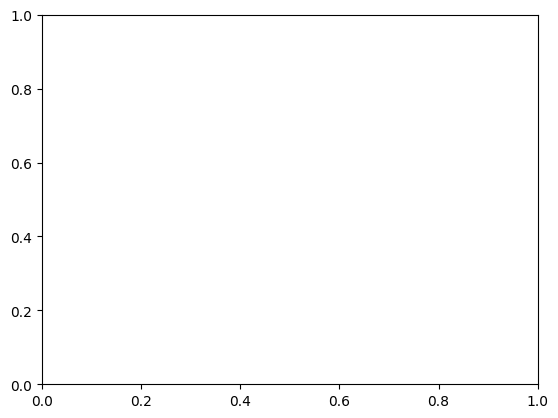

In [75]:
from matplotlib import pyplot as plt

def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features_names = [i for i in range(37)]

f_importances(a.coef_, features_names)